In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest



In [3]:
df = pd.read_csv('df_alldata.csv')

In [4]:
# Dataframe with funnel errors 

# Convert the 'date_time' column to datetime type
df['date_time'] = pd.to_datetime(df['date_time'])

# Sort the data by 'client_id', 'visitor_id', 'visit_id', and 'date_time' in ascending order
df_sorted = df.sort_values(by=['client_id', 'visitor_id', 'visit_id', 'date_time'], ascending=[True, True, True, True])

# Define the expected process_step order
expected_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Initialize the "errors" column
df_sorted['errors'] = ''

# Group the data by visit_id to evaluate each session
def evaluate_funnel(group):
    process_steps = group['process_step'].tolist()

    # Case 1: Visit_id has exactly the 5 steps in the correct order
    if process_steps == expected_steps:
        group['errors'] = 'correct_funnel_order_complete'
    
    # Case 2: Visit_id has all 5 steps but in the wrong order or with extra steps
    elif all(step in process_steps for step in expected_steps) and process_steps[-1] == 'confirm':
        group['errors'] = 'incorrect_funnel_order_complete'
    
    # Case 3: Visit_id does not have all 5 distinct steps
    else:
        group['errors'] = 'funnel_error'

    return group

# Apply the function to each visit_id group
df_with_errors = df_sorted.groupby('visit_id').apply(evaluate_funnel)


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\3822145233.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_errors = df_sorted.groupby('visit_id').apply(evaluate_funnel)


In [5]:
df_with_errors.to_csv("df_with_errors.csv")

In [6]:
# Dataframe with success column

In [7]:
# Create the new column 'funnel_success' based on the 'errors' column
df_with_errors['funnel_success'] = df_with_errors['errors'].apply(lambda x: 0 if x == 'funnel_error' else 1)

In [8]:
df = df_with_errors
df.to_csv("df_with_success.csv")

In [9]:
# Group by 'client_id', then for each 'client_id', get the unique 'visit_id' and calculate the % of successful funnels
success_percentage = df.groupby('client_id').apply(lambda group: pd.Series({
    'unique_visit_ids': group['visit_id'].nunique(),
    'success_percentage': group['funnel_success'].mean() * 100
})).reset_index()


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2037172356.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_percentage = df.groupby('client_id').apply(lambda group: pd.Series({


In [10]:
success_percentage.value_counts()

client_id  unique_visit_ids  success_percentage
555        1.0               100.000000            1
6685212    1.0               100.000000            1
6683515    1.0               100.000000            1
6683529    1.0               100.000000            1
6683623    1.0               100.000000            1
                                                  ..
3366593    1.0               100.000000            1
3366892    2.0               85.714286             1
3366913    1.0               100.000000            1
3367073    2.0               83.333333             1
9999729    2.0               0.000000              1
Name: count, Length: 40017, dtype: int64

In [11]:
# Calculate the average number of visits per client_id
average_visits_per_client = success_percentage['unique_visit_ids'].mean()

# Calculate the overall average success rate (amount of success funnel / amount of visit_id)
average_success_rate = df.groupby('client_id')['funnel_success'].mean().mean() * 100

average_visits_per_client, average_success_rate


(1.3038208761276457, 56.76317223405627)

In [12]:
# Grouping the data by 'client_id' and 'variation' to perform comparison between Test and Control groups
comparison = df.groupby(['variation', 'client_id']).apply(lambda group: pd.Series({
    'unique_visit_ids': group['visit_id'].nunique(),
    'success_percentage': group['funnel_success'].mean() * 100
})).reset_index()

# Calculate the average number of visits per client_id and success rate for Test and Control groups
comparison_summary = comparison.groupby('variation').agg({
    'unique_visit_ids': 'mean',
    'success_percentage': 'mean'
}).reset_index()


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\3112683169.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comparison = df.groupby(['variation', 'client_id']).apply(lambda group: pd.Series({


In [13]:
comparison_summary

,variation,unique_visit_ids,success_percentage
0,Control,1.296985,53.714009
1,Test,1.309416,59.258786


In [14]:
# Remove unnecessary columns and keep the relevant ones
df_clean = df[['visit_id', 'client_id', 'variation', 'funnel_success']]

# Group by client_id to calculate the total visits and average success rate for each client
client_visits = df_clean.groupby('client_id').agg(
    total_visits=('visit_id', 'nunique'), 
    avg_success_rate=('funnel_success', 'mean')
).reset_index()

# Overall analysis
overall_total_visits = client_visits['total_visits'].sum()
overall_avg_success_rate = client_visits['avg_success_rate'].mean()

# Comparative analysis by test vs control groups
variation_grouped = df_clean.groupby(['variation', 'client_id']).agg(
    total_visits=('visit_id', 'nunique'),
    avg_success_rate=('funnel_success', 'mean')
).reset_index()

test_group = variation_grouped[variation_grouped['variation'] == 'Test']
control_group = variation_grouped[variation_grouped['variation'] == 'Control']

test_avg_visits = test_group['total_visits'].mean()
test_avg_success_rate = test_group['avg_success_rate'].mean()

control_avg_visits = control_group['total_visits'].mean()
control_avg_success_rate = control_group['avg_success_rate'].mean()

# Display overall and comparative results
overall_results = {
    'Overall Total Visits': overall_total_visits,
    'Overall Average Success Rate': overall_avg_success_rate,
    'Test Group Average Visits': test_avg_visits,
    'Test Group Average Success Rate': test_avg_success_rate,
    'Control Group Average Visits': control_avg_visits,
    'Control Group Average Success Rate': control_avg_success_rate
}

overall_results


{'Overall Total Visits': 52175,
 'Overall Average Success Rate': 0.5676317223405627,
 'Test Group Average Visits': 1.3094156139234754,
 'Test Group Average Success Rate': 0.5925878625850841,
 'Control Group Average Visits': 1.2969851757259452,
 'Control Group Average Success Rate': 0.5371400882158088}

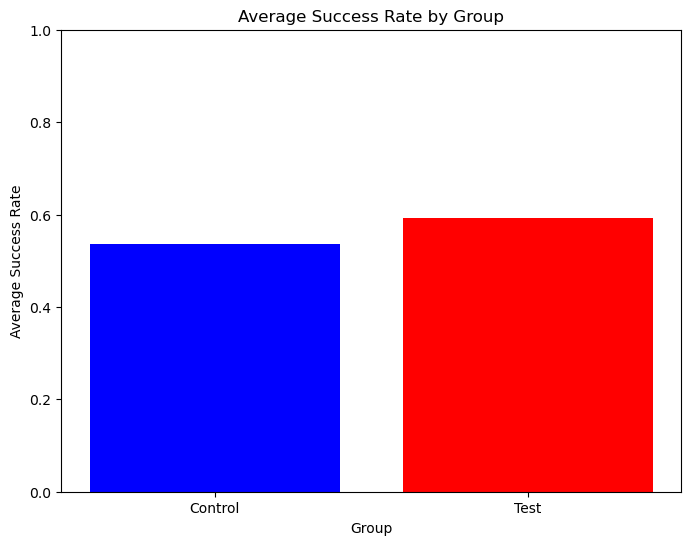

In [15]:
# Plot the success rates by group
groups = ['Control', 'Test']
success_rates = [control_avg_success_rate, test_avg_success_rate]

plt.figure(figsize=(8, 6))
plt.bar(groups, success_rates, color=['blue', 'red'])
plt.xlabel('Group')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Group')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 to represent percentages

# Display the plot
plt.show()


In [16]:
success_rates

[0.5371400882158088, 0.5925878625850841]

C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\767436914.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_by_age_new = df.groupby('age_group_new').agg(


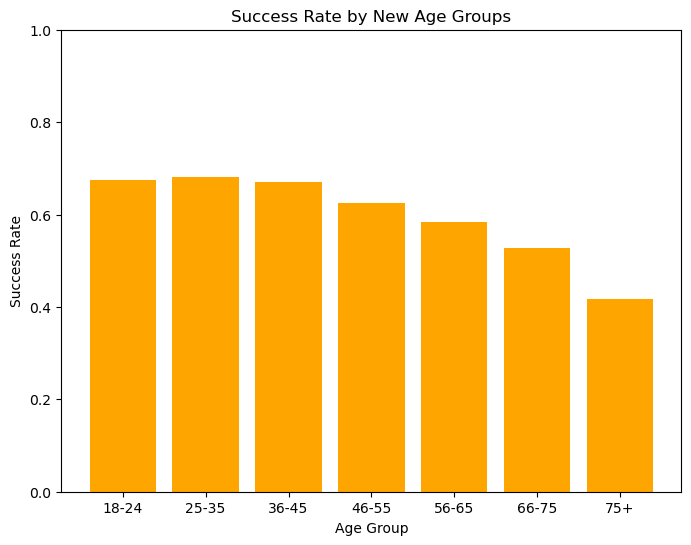

In [17]:
# Modify the age bins and labels as per the new ranges
age_bins_new = [18, 24, 35, 45, 55, 65, 75, 100]
age_labels_new = ['18-24', '25-35', '36-45', '46-55', '56-65', '66-75', '75+']
df['age_group_new'] = pd.cut(df['age'], bins=age_bins_new, labels=age_labels_new)

# Group by the new age groups to calculate the success rate for each group
success_rate_by_age_new = df.groupby('age_group_new').agg(
    total_visits=('visit_id', 'nunique'),
    success_rate=('funnel_success', 'mean')
).reset_index()

# Plot the success rate by the new age group
plt.figure(figsize=(8, 6))
plt.bar(success_rate_by_age_new['age_group_new'], success_rate_by_age_new['success_rate'], color='orange')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.title('Success Rate by New Age Groups')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 to represent percentages

# Display the plot
plt.show()


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\1117169872.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_by_age_group_variation = df.groupby(['age_group_new', 'variation']).agg(


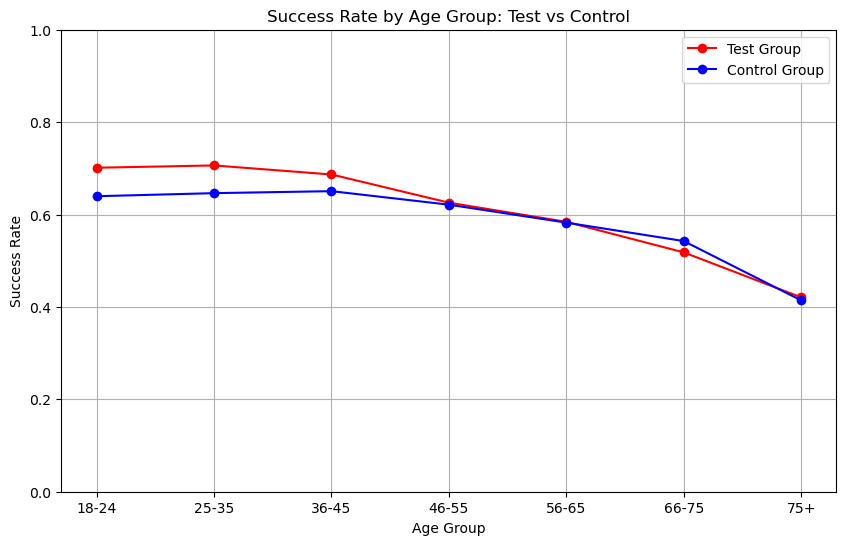

In [18]:
# Group by age group and variation to calculate success rate for Test and Control groups
success_rate_by_age_group_variation = df.groupby(['age_group_new', 'variation']).agg(
    total_visits=('visit_id', 'nunique'),
    success_rate=('funnel_success', 'mean')
).reset_index()

# Separate data for Test and Control groups
test_data = success_rate_by_age_group_variation[success_rate_by_age_group_variation['variation'] == 'Test']
control_data = success_rate_by_age_group_variation[success_rate_by_age_group_variation['variation'] == 'Control']

# Plot the success rates by age group for Test and Control
plt.figure(figsize=(10, 6))
plt.plot(test_data['age_group_new'], test_data['success_rate'], marker='o', label='Test Group', color='red')
plt.plot(control_data['age_group_new'], control_data['success_rate'], marker='o', label='Control Group', color='blue')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.title('Success Rate by Age Group: Test vs Control')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 to represent percentages
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [19]:

# Calculate success rate based on unique successful visits (1 success max per visit)
df_unique_visits = df_clean.drop_duplicates(subset=['visit_id'])

# Group by variation to calculate the number of visits and the rate of successful visits
visits_and_success_unique = df_unique_visits.groupby('variation').agg(
    total_visits=('visit_id', 'nunique'),
    successful_visits=('funnel_success', 'sum')
).reset_index()

# Calculate success rate (successful visits / total visits)
visits_and_success_unique['success_rate'] = visits_and_success_unique['successful_visits'] / visits_and_success_unique['total_visits']

# Display the updated success rate
visits_and_success_unique



,variation,total_visits,successful_visits,success_rate
0,Control,23273,10264,0.441026
1,Test,28709,14017,0.488244


In [20]:
from scipy import stats
import numpy as np

# Prepare data for two-sample t-test
control_success_rates = df_unique_visits[df_unique_visits['variation'] == 'Control']['funnel_success']
test_success_rates = df_unique_visits[df_unique_visits['variation'] == 'Test']['funnel_success']

# Perform two-sample t-test
t_stat, p_value_ttest = stats.ttest_ind(control_success_rates, test_success_rates)

# Prepare data for chi-square test (success vs failure for control and test groups)
control_successes = control_success_rates.sum()
control_failures = len(control_success_rates) - control_successes
test_successes = test_success_rates.sum()
test_failures = len(test_success_rates) - test_successes

# Create a contingency table
contingency_table = np.array([[control_successes, control_failures], [test_successes, test_failures]])

# Perform chi-square test
chi2_stat, p_value_chi2, _, _ = stats.chi2_contingency(contingency_table)

# Output the results of both tests
t_test_results = {
    't_statistic': t_stat,
    'p_value_ttest': p_value_ttest
}

chi2_test_results = {
    'chi2_statistic': chi2_stat,
    'p_value_chi2': p_value_chi2
}

t_test_results, chi2_test_results


({'t_statistic': -10.741417690133224, 'p_value_ttest': 6.940818820769825e-27},
 {'chi2_statistic': 114.9373352939181, 'p_value_chi2': 8.12240401629767e-27})

In [21]:
# Calculate the difference in success rates
success_rate_difference = test_avg_success_rate - control_avg_success_rate

# Determine if the A/B test is successful based on the 5% criterion
is_successful = success_rate_difference >= 0.05

# Create a summary of the results
results_summary = {
    'Test Group Success Rate (%)': round(test_avg_success_rate * 100, 2),
    'Control Group Success Rate (%)': round(control_avg_success_rate * 100, 2),
    'Success Rate Difference (%)': round(success_rate_difference * 100, 2),
    'Is A/B Test Successful (5% criterion)': is_successful,
    't-test p-value': p_value_ttest,
    'Chi-square p-value': p_value_chi2
}

results_summary


{'Test Group Success Rate (%)': 59.26,
 'Control Group Success Rate (%)': 53.71,
 'Success Rate Difference (%)': 5.54,
 'Is A/B Test Successful (5% criterion)': True,
 't-test p-value': 6.940818820769825e-27,
 'Chi-square p-value': 8.12240401629767e-27}

In [22]:
# Deduplicate the data by unique visit_id and client_id, keeping only one success or failure per unique visit
df_dedup = df_clean.drop_duplicates(subset=['visit_id', 'client_id'])

# Group by client_id and variation to calculate unique visits and success rate, ensuring only one success or failure per visit
client_visit_success_updated = df_dedup.groupby(['client_id', 'variation']).agg(
    unique_visits=('visit_id', 'nunique'),
    total_successes=('funnel_success', 'sum')
).reset_index()

# Calculate the success rate per client (based on one success or failure per unique visit)
client_visit_success_updated['success_rate'] = client_visit_success_updated['total_successes'] / client_visit_success_updated['unique_visits']

# Separate data for Test and Control groups
client_visit_success_updated_test = client_visit_success_updated[client_visit_success_updated['variation'] == 'Test']
client_visit_success_updated_control = client_visit_success_updated[client_visit_success_updated['variation'] == 'Control']

# Display the first few rows of the updated analysis for both groups
client_visit_success_updated_test.head(), client_visit_success_updated_control.head()




(   client_id variation  unique_visits  total_successes  success_rate
 0        555      Test              1                1           1.0
 1        647      Test              1                1           1.0
 2        934      Test              1                0           0.0
 8       1516      Test              2                1           0.5
 9       1643      Test              2                0           0.0,
    client_id variation  unique_visits  total_successes  success_rate
 3       1028   Control              1                0           0.0
 4       1186   Control              2                0           0.0
 5       1195   Control              1                1           1.0
 6       1197   Control              1                1           1.0
 7       1368   Control              1                0           0.0)

In [23]:
# Calculate the average success rate across all clients for Test and Control groups
avg_success_rate_test = client_visit_success_updated_test['success_rate'].mean()
avg_success_rate_control = client_visit_success_updated_control['success_rate'].mean()

# Summarize the average success rates
success_rate_summary = {
    'Average Success Rate - Test Group (%)': round(avg_success_rate_test * 100, 2),
    'Average Success Rate - Control Group (%)': round(avg_success_rate_control * 100, 2)
}

success_rate_summary


{'Average Success Rate - Test Group (%)': 56.05,
 'Average Success Rate - Control Group (%)': 50.93}

In [24]:
df_with_success = pd.read_csv("df_with_success.csv")
df_with_success

,visit_id,Unnamed: 1,client_id,variation,tenure_year,tenure_month,age,gender,accounts,balance,calls_semester,logons_semester,balance_thousands,visitor_id,visit_id.1,process_step,date_time,errors,funnel_success
0,100012776_37918976071_457913,111379,3561384,Test,4.0,56.0,59.5,U,2.0,63130.44,6.0,9.0,63.13,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,funnel_error,0
1,100012776_37918976071_457913,111378,3561384,Test,4.0,56.0,59.5,U,2.0,63130.44,6.0,9.0,63.13,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,funnel_error,0
2,100019538_17884295066_43909,246767,7338123,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,26.44,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,incorrect_funnel_order_complete,1
3,100019538_17884295066_43909,246766,7338123,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,26.44,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,incorrect_funnel_order_complete,1
4,100019538_17884295066_43909,246765,7338123,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,26.44,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,incorrect_funnel_order_complete,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241146,999988789_76411676596_272843,99589,6627522,Test,18.0,227.0,58.0,F,2.0,1056775.54,6.0,9.0,1056.78,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,funnel_error,0
241147,999988789_76411676596_272843,99588,6627522,Test,18.0,227.0,58.0,F,2.0,1056775.54,6.0,9.0,1056.78,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,funnel_error,0
241148,999988789_76411676596_272843,99587,6627522,Test,18.0,227.0,58.0,F,2.0,1056775.54,6.0,9.0,1056.78,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,funnel_error,0
241149,999988789_76411676596_272843,99586,6627522,Test,18.0,227.0,58.0,F,2.0,1056775.54,6.0,9.0,1056.78,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,funnel_error,0


In [25]:

# Step 1: Convert 'date_time' to datetime format
df_with_success['date_time'] = pd.to_datetime(df_with_success['date_time'], errors='coerce')

# Step 2: Sort by client_id, visit_id, and date_time to ensure proper sequence
df_with_success = df_with_success.sort_values(by=['client_id', 'visit_id', 'date_time'], ignore_index=True)

# Step 3: Calculate 'time_spent' as the difference between consecutive steps within the same client and visit
df_with_success['next_date_time'] = df_with_success.groupby(['client_id', 'visit_id'])['date_time'].shift(-1)
df_with_success['time_spent'] = (df_with_success['next_date_time'] - df_with_success['date_time']).dt.total_seconds()

# Step 4: Remove rows where 'time_spent' is NaN, which indicates the last step in each sequence
df_steps_duration_corrected = df_with_success.dropna(subset=['time_spent'])

# Step 5: Remove the 'confirm' step, as it's the final step and shouldn't have a following step
df_steps_duration_corrected = df_steps_duration_corrected[df_steps_duration_corrected['process_step'] != 'confirm']

# Step 6: Recalculate the average time spent per step, grouped by 'variation' and 'process_step'
avg_step_duration_corrected = df_steps_duration_corrected.groupby(['variation', 'process_step'])['time_spent'].mean().reset_index()
avg_step_duration_corrected.rename(columns={'time_spent': 'avg_time_spent_seconds'}, inplace=True)

# Display the final corrected results
print(avg_step_duration_corrected)

  variation process_step  avg_time_spent_seconds
0   Control        start               68.900262
1   Control       step_1               47.337968
2   Control       step_2               92.559155
3   Control       step_3              143.655161
4      Test        start               60.200626
5      Test       step_1               62.049775
6      Test       step_2               88.366531
7      Test       step_3              131.994556


In [26]:
# Convert the 'date_time' column to datetime type
df_with_success['date_time'] = pd.to_datetime(df_with_success['date_time'])

# Group by 'visit_id' and calculate the time difference for each visit
df_with_success['visit_duration_seconds'] = df_with_success.groupby('visit_id')['date_time'].transform(lambda x: (x.max() - x.min()).total_seconds())

df_with_success


,visit_id,Unnamed: 1,client_id,variation,tenure_year,tenure_month,age,gender,accounts,balance,...,balance_thousands,visitor_id,visit_id.1,process_step,date_time,errors,funnel_success,next_date_time,time_spent,visit_duration_seconds
0,637149525_38041617439_716659,73801,555,Test,3.0,46.0,29.5,U,2.0,25454.66,...,25.45,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,correct_funnel_order_complete,1,2017-04-15 12:58:03,7.0,158.0
1,637149525_38041617439_716659,73800,555,Test,3.0,46.0,29.5,U,2.0,25454.66,...,25.45,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,correct_funnel_order_complete,1,2017-04-15 12:58:35,32.0,158.0
2,637149525_38041617439_716659,73799,555,Test,3.0,46.0,29.5,U,2.0,25454.66,...,25.45,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,correct_funnel_order_complete,1,2017-04-15 13:00:14,99.0,158.0
3,637149525_38041617439_716659,73798,555,Test,3.0,46.0,29.5,U,2.0,25454.66,...,25.45,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,correct_funnel_order_complete,1,2017-04-15 13:00:34,20.0,158.0
4,637149525_38041617439_716659,73797,555,Test,3.0,46.0,29.5,U,2.0,25454.66,...,25.45,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,correct_funnel_order_complete,1,NaT,NaN,158.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241146,493310979_9209676464_421146,109815,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,...,107.06,843385170_36953471821,493310979_9209676464_421146,step_1,2017-04-20 14:22:49,funnel_error,0,2017-04-20 14:27:36,287.0,450.0
241147,493310979_9209676464_421146,109814,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,...,107.06,843385170_36953471821,493310979_9209676464_421146,step_2,2017-04-20 14:27:36,funnel_error,0,2017-04-20 14:28:57,81.0,450.0
241148,493310979_9209676464_421146,109813,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,...,107.06,843385170_36953471821,493310979_9209676464_421146,start,2017-04-20 14:28:57,funnel_error,0,NaT,NaN,450.0
241149,99583652_41711450505_426179,109812,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,...,107.06,604429154_69247391147,99583652_41711450505_426179,start,2017-04-05 13:40:49,funnel_error,0,2017-04-05 13:41:04,15.0,15.0


In [27]:
# Calculate the average visit duration for successful vs unsuccessful funnels
avg_duration_by_success = df_with_success.groupby('funnel_success')['visit_duration_seconds'].mean()

# Calculate the average visit duration for test vs control groups
avg_duration_by_group = df_with_success.groupby('variation')['visit_duration_seconds'].mean()

# Display the results
avg_duration_by_success, avg_duration_by_group


(funnel_success
 0    452.276329
 1    503.624113
 Name: visit_duration_seconds, dtype: float64,
 variation
 Control    448.247269
 Test       509.946966
 Name: visit_duration_seconds, dtype: float64)

In [28]:
# Group by both funnel success and variation to calculate the average visit duration
avg_duration_by_success_and_group = df_with_success.groupby(['funnel_success', 'variation'])['visit_duration_seconds'].mean()

# Display the result
avg_duration_by_success_and_group


funnel_success  variation
0               Control      412.571833
                Test         482.484295
1               Control      471.324734
                Test         526.443078
Name: visit_duration_seconds, dtype: float64

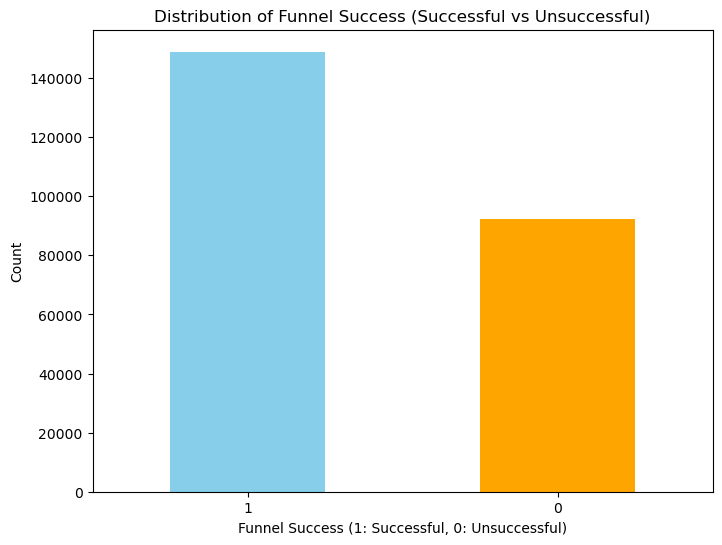

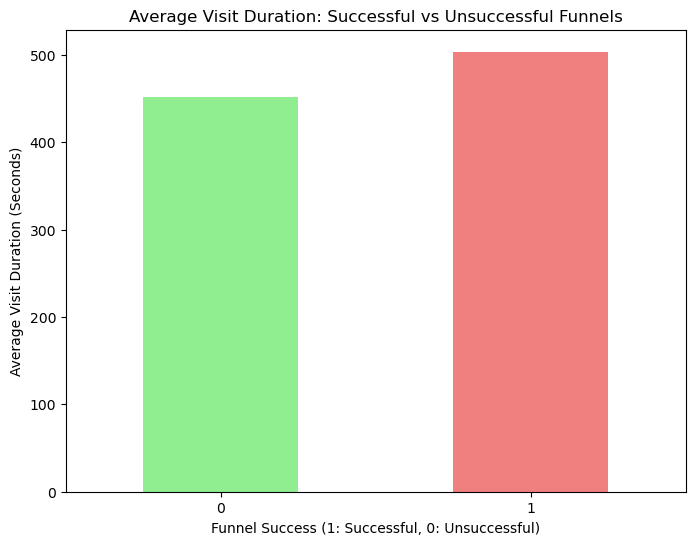

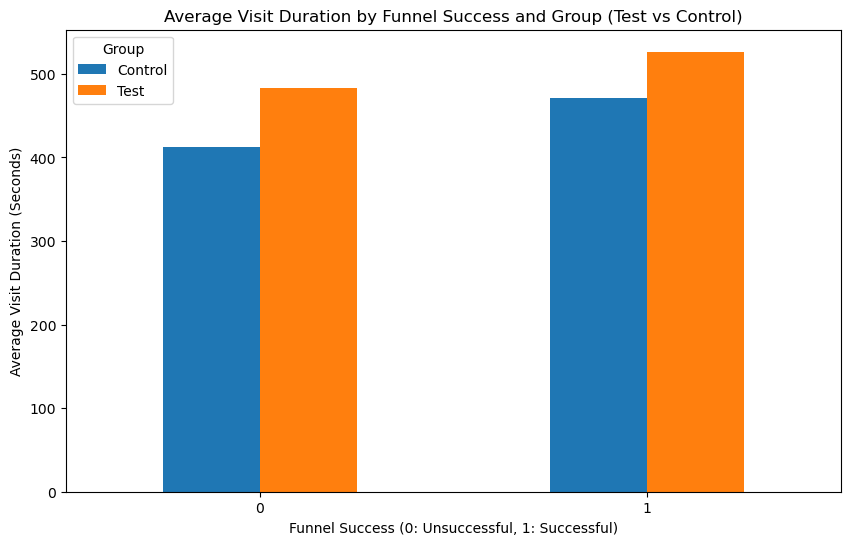

In [29]:
# Funnel success distribution
plt.figure(figsize=(8,6))
df['funnel_success'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Funnel Success (Successful vs Unsuccessful)')
plt.xlabel('Funnel Success (1: Successful, 0: Unsuccessful)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Average visit duration: successful vs unsuccessful funnels
plt.figure(figsize=(8,6))
avg_duration_by_success.plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Average Visit Duration: Successful vs Unsuccessful Funnels')
plt.xlabel('Funnel Success (1: Successful, 0: Unsuccessful)')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.show()

# Average visit duration: test vs control groups for successful/unsuccessful funnels
avg_duration_by_success_and_group.unstack().plot(kind='bar', figsize=(10,6))
plt.title('Average Visit Duration by Funnel Success and Group (Test vs Control)')
plt.xlabel('Funnel Success (0: Unsuccessful, 1: Successful)')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.legend(title="Group", loc='upper left')
plt.show()


In [30]:
df = df_with_success

In [31]:
# 2. Average Visit Duration (Control vs. Test)
avg_duration_by_group = df.groupby('variation')['visit_duration_seconds'].mean()

# 3. Age Distribution (Control vs. Test)
avg_age_by_group = df.groupby('variation')['age'].mean()

# 4. Tenure Year and Month Comparison (Control vs. Test)
avg_tenure_year_by_group = df.groupby('variation')['tenure_year'].mean()
avg_tenure_month_by_group = df.groupby('variation')['tenure_month'].mean()

# 5. Number of Accounts (Control vs. Test)
avg_accounts_by_group = df.groupby('variation')['accounts'].mean()

# 6. Balance Distribution (Control vs. Test)
avg_balance_by_group = df.groupby('variation')['balance'].mean()

# 7. Calls per Semester (Control vs. Test)
avg_calls_by_group = df.groupby('variation')['calls_semester'].mean()

# 8. Logons per Semester (Control vs. Test)
avg_logons_by_group = df.groupby('variation')['logons_semester'].mean()

# 9. Visit Success Based on Gender (Control vs. Test)
success_rate_by_gender_and_group = df.groupby(['gender', 'variation'])['funnel_success'].mean()

# 10. Balance for Successful Funnels (Control vs. Test)
avg_balance_successful_by_group = df[df['funnel_success'] == 1].groupby('variation')['balance'].mean()

# 11. Visit Duration for Successful Funnels (Control vs. Test)
avg_duration_successful_by_group = df[df['funnel_success'] == 1].groupby('variation')['visit_duration_seconds'].mean()

# 12. Visit Duration for Unsuccessful Funnels (Control vs. Test)
avg_duration_unsuccessful_by_group = df[df['funnel_success'] == 0].groupby('variation')['visit_duration_seconds'].mean()

# 13. Success Rate for Different Age Groups (Control vs. Test)
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, 100], labels=['<18', '18-35', '35-50', '50-65', '65+'])
success_rate_by_age_group = df.groupby(['age_group', 'variation'])['funnel_success'].mean()

# 14. Impact of Account Balance on Funnel Success (Control vs. Test)
balance_success_rate = df.groupby(pd.cut(df['balance'], bins=[0, 10000, 50000, 100000, 500000]))['funnel_success'].mean()

# 15. Relationship Between Logons and Funnel Success (Control vs. Test)
logon_success_rate = df.groupby(pd.cut(df['logons_semester'], bins=[0, 5, 10, 20, 50]))['funnel_success'].mean()

# Display all the calculated insights
{
    "Average Visit Duration by Group": avg_duration_by_group,
    "Average Age by Group": avg_age_by_group,
    "Average Tenure Year by Group": avg_tenure_year_by_group,
    "Average Tenure Month by Group": avg_tenure_month_by_group,
    "Average Accounts by Group": avg_accounts_by_group,
    "Average Balance by Group": avg_balance_by_group,
    "Average Calls by Group": avg_calls_by_group,
    "Average Logons by Group": avg_logons_by_group,
    "Success Rate by Gender and Group": success_rate_by_gender_and_group,
    "Average Balance for Successful Funnels by Group": avg_balance_successful_by_group,
    "Average Duration for Successful Funnels by Group": avg_duration_successful_by_group,
    "Average Duration for Unsuccessful Funnels by Group": avg_duration_unsuccessful_by_group,
    "Success Rate by Age Group": success_rate_by_age_group,
    "Balance Success Rate": balance_success_rate,
    "Logon Success Rate": logon_success_rate
}


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\4174175512.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_by_age_group = df.groupby(['age_group', 'variation'])['funnel_success'].mean()
C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\4174175512.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balance_success_rate = df.groupby(pd.cut(df['balance'], bins=[0, 10000, 50000, 100000, 500000]))['funnel_success'].mean()
C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\4174175512.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version

{'Average Visit Duration by Group': variation
 Control    448.247269
 Test       509.946966
 Name: visit_duration_seconds, dtype: float64,
 'Average Age by Group': variation
 Control    48.274144
 Test       48.804026
 Name: age, dtype: float64,
 'Average Tenure Year by Group': variation
 Control    12.090252
 Test       12.153982
 Name: tenure_year, dtype: float64,
 'Average Tenure Month by Group': variation
 Control    151.093936
 Test       151.900019
 Name: tenure_month, dtype: float64,
 'Average Accounts by Group': variation
 Control    2.272410
 Test       2.253427
 Name: accounts, dtype: float64,
 'Average Balance by Group': variation
 Control    160221.922984
 Test       161112.719731
 Name: balance, dtype: float64,
 'Average Calls by Group': variation
 Control    3.168346
 Test       3.153395
 Name: calls_semester, dtype: float64,
 'Average Logons by Group': variation
 Control    6.205103
 Test       6.193482
 Name: logons_semester, dtype: float64,
 'Success Rate by Gender and

In [32]:
avg_duration_by_group.to_csv("avg_duration_by_group.csv")

In [33]:
avg_duration_successful_by_group.to_csv("avg_duration_successful_by_group.csv")

In [34]:
avg_duration_unsuccessful_by_group.to_csv("avg_duration_unsuccessful_by_group.csv")

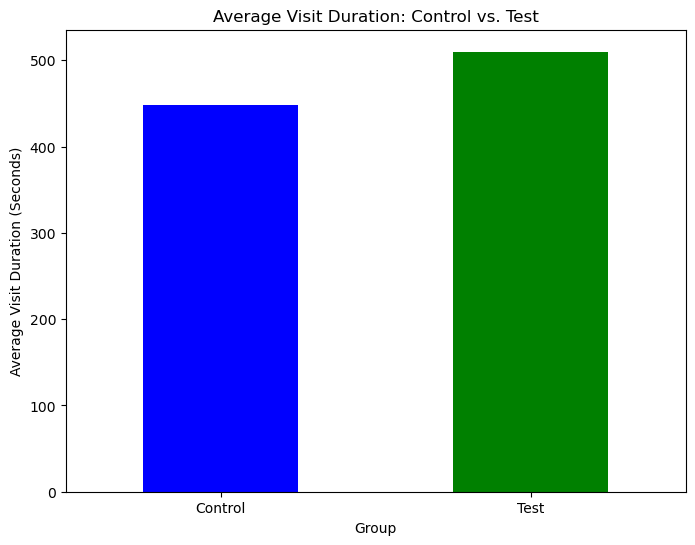

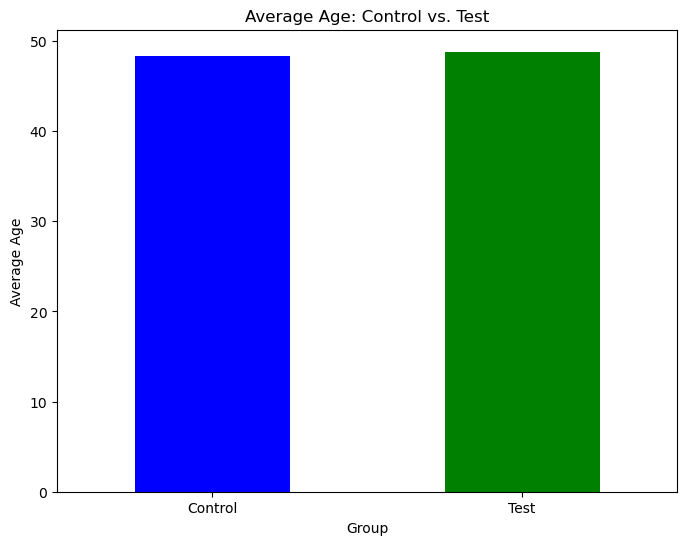

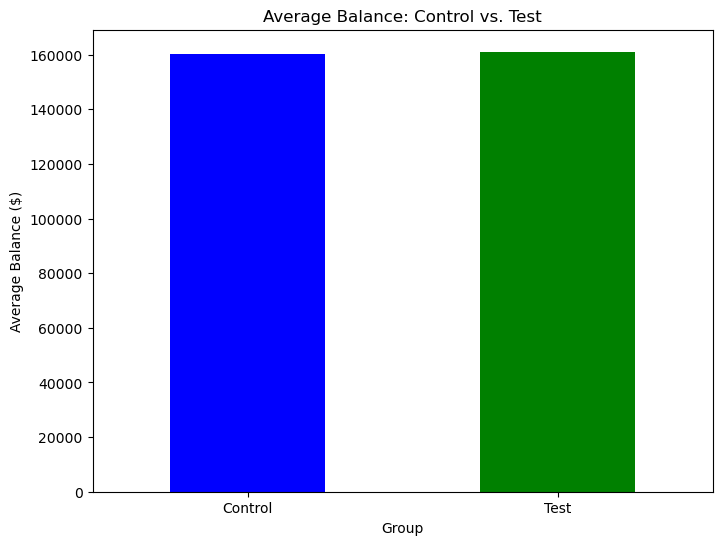

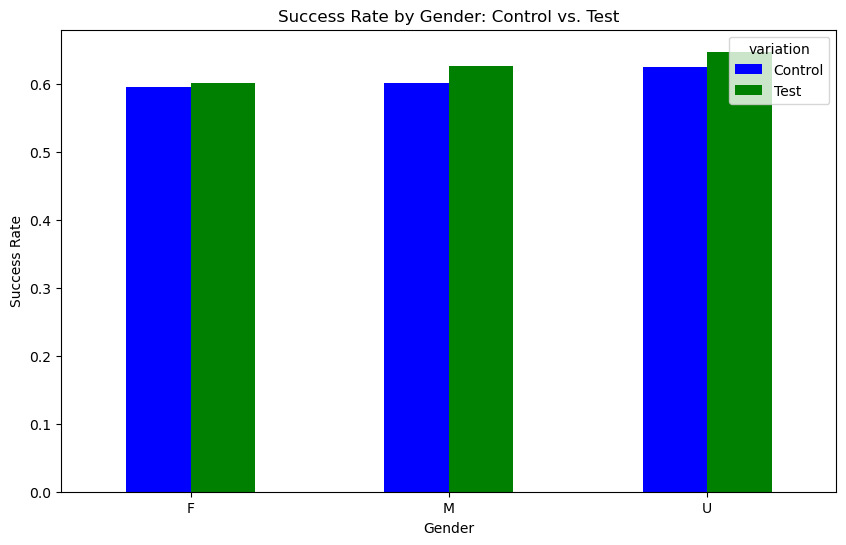

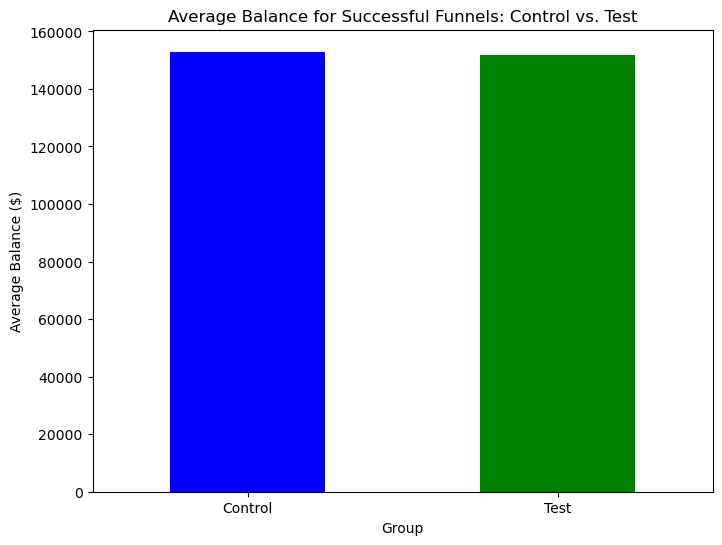

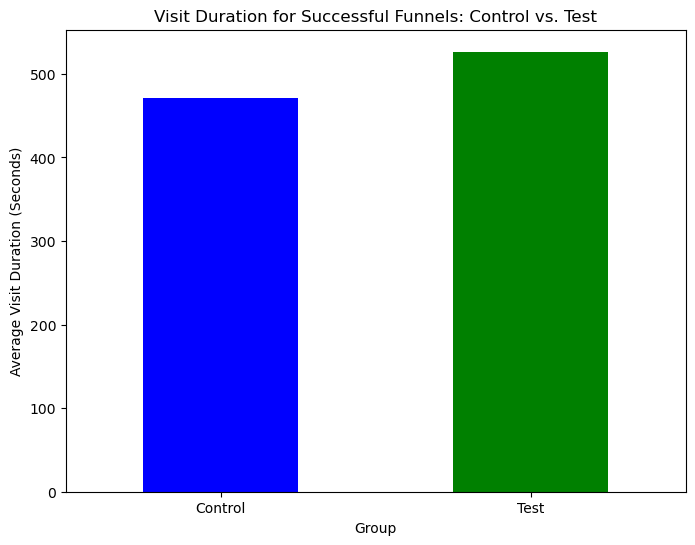

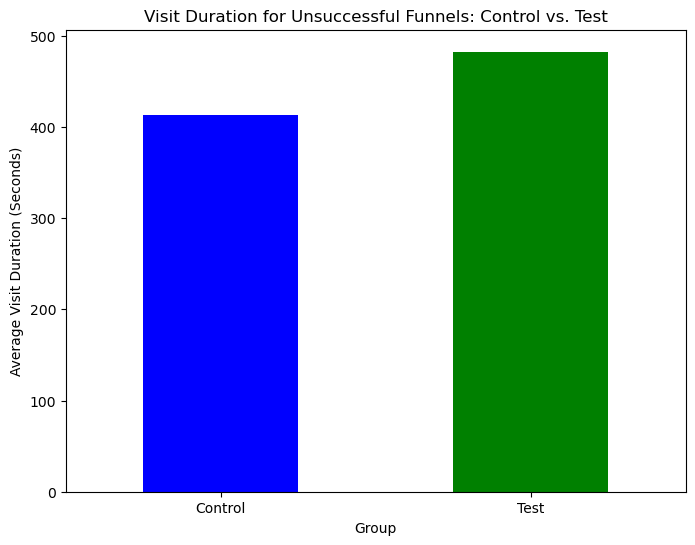

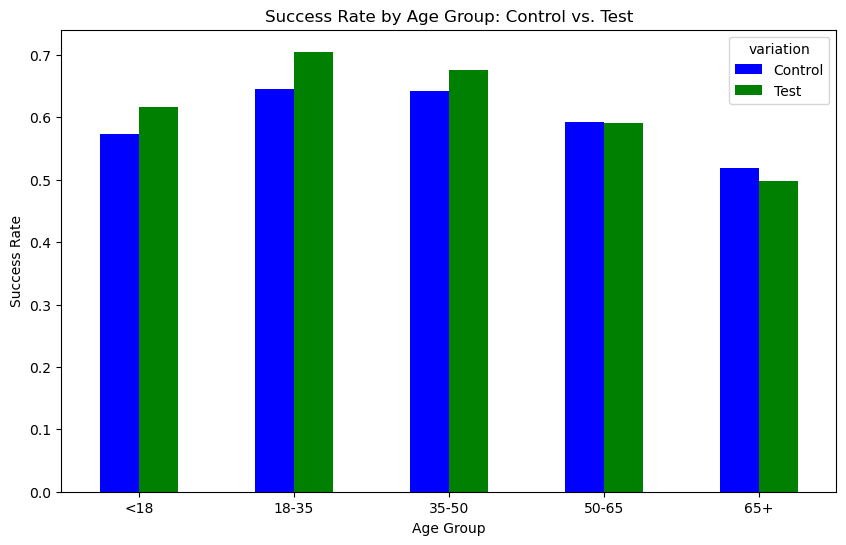

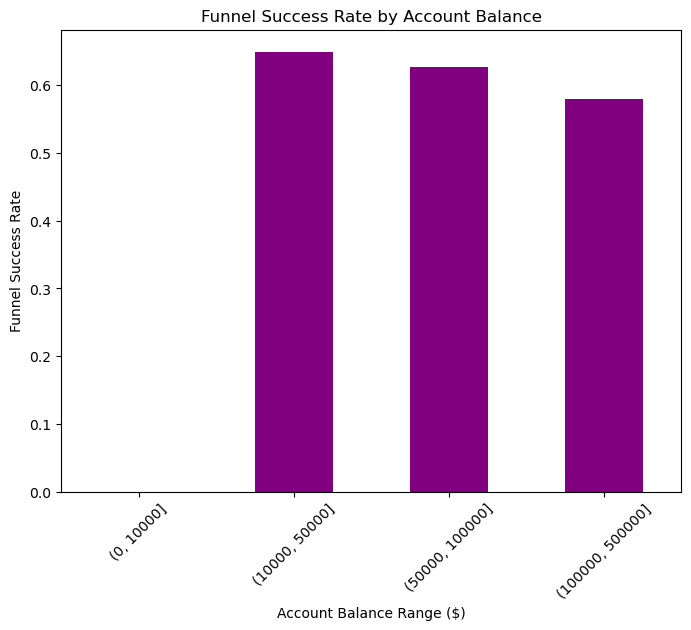

In [35]:
# Focus on relevant insights:
# We will remove the less relevant analyses such as tenure, number of accounts, calls per semester, and logons per semester.

# Relevant analyses:
# 1. Success Rates by Group
# 2. Average Visit Duration by Group
# 3. Age Distribution (Control vs. Test)
# 4. Balance Distribution (Control vs. Test)
# 5. Success Rate by Gender and Group
# 6. Balance for Successful Funnels (Control vs. Test)
# 7. Visit Duration for Successful Funnels (Control vs. Test)
# 8. Visit Duration for Unsuccessful Funnels (Control vs. Test)
# 9. Success Rate by Age Group
# 10. Impact of Balance on Funnel Success

# Plotting graphs for relevant insights

# Plot 2: Average Visit Duration by Group
plt.figure(figsize=(8,6))
avg_duration_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Visit Duration: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.show()

# Plot 3: Age Distribution (Control vs. Test)
plt.figure(figsize=(8,6))
avg_age_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Age: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Age')
plt.xticks(rotation=0)
plt.show()

# Plot 4: Balance Distribution (Control vs. Test)
plt.figure(figsize=(8,6))
avg_balance_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Balance: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Balance ($)')
plt.xticks(rotation=0)
plt.show()

# Plot 5: Success Rate by Gender and Group
success_rate_by_gender_and_group.unstack().plot(kind='bar', figsize=(10,6), color=['blue', 'green'])
plt.title('Success Rate by Gender: Control vs. Test')
plt.xlabel('Gender')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.show()

# Plot 6: Balance for Successful Funnels (Control vs. Test)
plt.figure(figsize=(8,6))
avg_balance_successful_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Balance for Successful Funnels: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Balance ($)')
plt.xticks(rotation=0)
plt.show()

# Plot 7: Visit Duration for Successful Funnels (Control vs. Test)
plt.figure(figsize=(8,6))
avg_duration_successful_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Visit Duration for Successful Funnels: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.show()

# Plot 8: Visit Duration for Unsuccessful Funnels (Control vs. Test)
plt.figure(figsize=(8,6))
avg_duration_unsuccessful_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Visit Duration for Unsuccessful Funnels: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.show()

# Plot 9: Success Rate by Age Group (Control vs. Test)
success_rate_by_age_group.unstack().plot(kind='bar', figsize=(10,6), color=['blue', 'green'])
plt.title('Success Rate by Age Group: Control vs. Test')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.show()

# Plot 10: Impact of Balance on Funnel Success
plt.figure(figsize=(8,6))
balance_success_rate.plot(kind='bar', color='purple')
plt.title('Funnel Success Rate by Account Balance')
plt.xlabel('Account Balance Range ($)')
plt.ylabel('Funnel Success Rate')
plt.xticks(rotation=45)
plt.show()


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2879472102.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_by_age_group_unique = df_unique_visits.groupby(['age_group', 'variation'])['funnel_success'].mean()
C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2879472102.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balance_success_rate_unique = df_unique_visits.groupby(pd.cut(df_unique_visits['balance'], bins=[0, 10000, 50000, 100000, 500000]))['funnel_success'].mean()


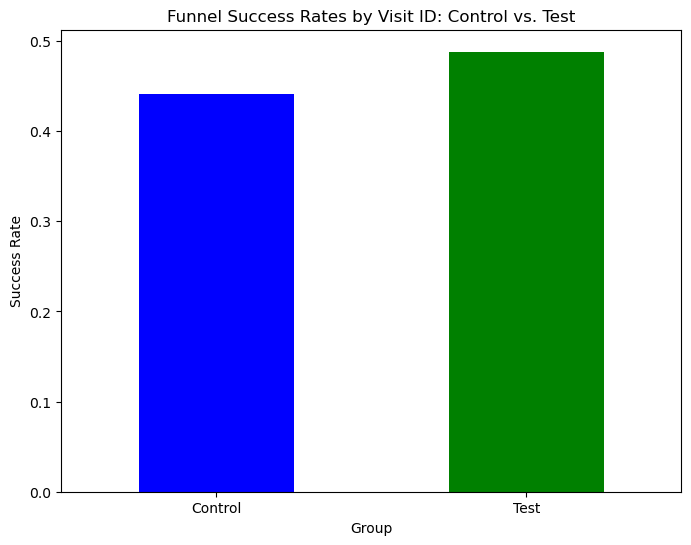

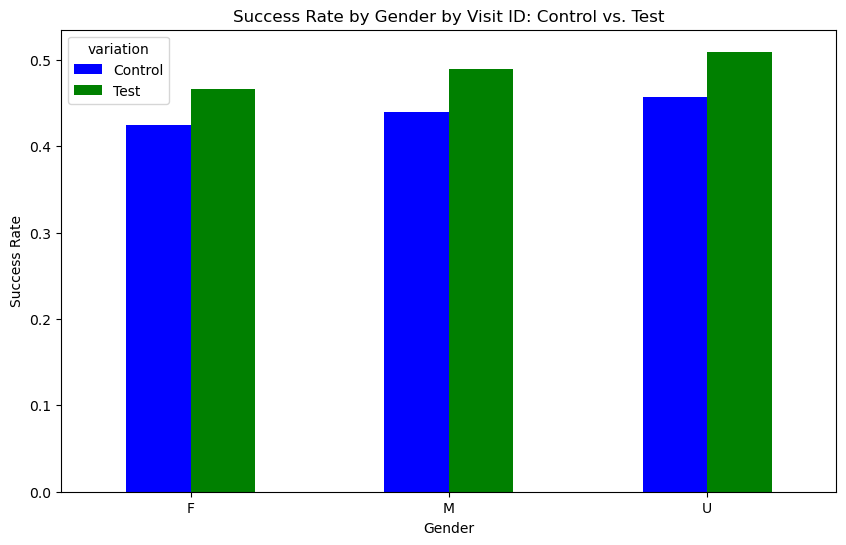

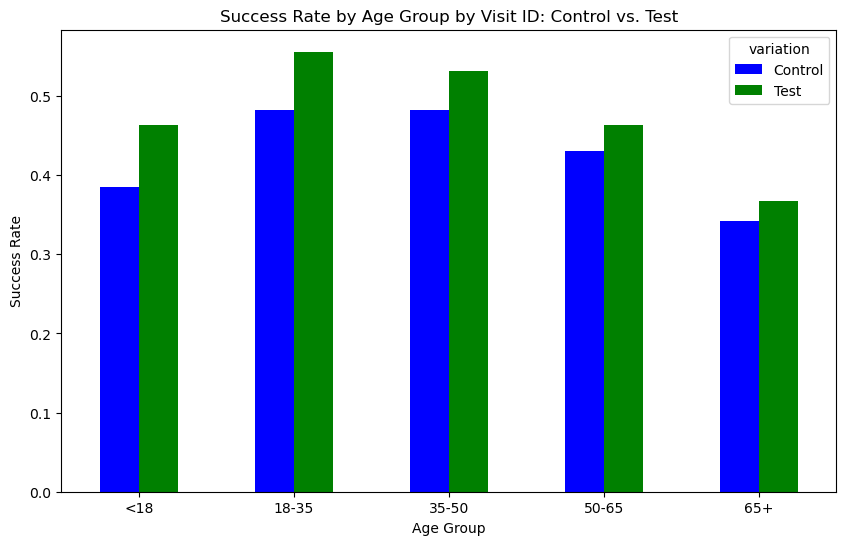

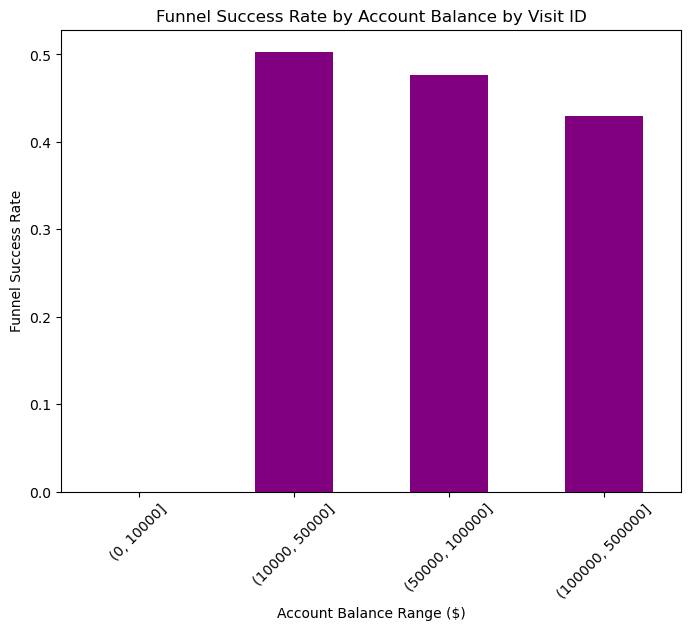

In [36]:
# To calculate the success rate correctly, we need to count only one "funnel success" per visit_id.
# First, we will drop duplicates by visit_id and take the first row for each unique visit_id.

# Remove duplicates to count success per visit_id
df_unique_visits = df.drop_duplicates(subset=['visit_id'], keep='first')

# Recalculate success rates by group (Control vs. Test)
success_rates_by_group_unique = df_unique_visits.groupby('variation')['funnel_success'].mean()

# Recalculate success rate by gender and group (Control vs. Test)
success_rate_by_gender_and_group_unique = df_unique_visits.groupby(['gender', 'variation'])['funnel_success'].mean()

# Recalculate success rate by age group (Control vs. Test)
success_rate_by_age_group_unique = df_unique_visits.groupby(['age_group', 'variation'])['funnel_success'].mean()

# Recalculate balance success rate (Funnel success based on balance ranges)
balance_success_rate_unique = df_unique_visits.groupby(pd.cut(df_unique_visits['balance'], bins=[0, 10000, 50000, 100000, 500000]))['funnel_success'].mean()

# Plot 1: Success Rates by Group (unique visits)
plt.figure(figsize=(8,6))
success_rates_by_group_unique.plot(kind='bar', color=['blue', 'green'])
plt.title('Funnel Success Rates by Visit ID: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.show()

# Plot 2: Success Rate by Gender and Group (unique visits)
success_rate_by_gender_and_group_unique.unstack().plot(kind='bar', figsize=(10,6), color=['blue', 'green'])
plt.title('Success Rate by Gender by Visit ID: Control vs. Test')
plt.xlabel('Gender')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.show()

# Plot 3: Success Rate by Age Group (unique visits)
success_rate_by_age_group_unique.unstack().plot(kind='bar', figsize=(10,6), color=['blue', 'green'])
plt.title('Success Rate by Age Group by Visit ID: Control vs. Test')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.show()

# Plot 4: Impact of Balance on Funnel Success by Visit ID (unique visits)
plt.figure(figsize=(8,6))
balance_success_rate_unique.plot(kind='bar', color='purple')
plt.title('Funnel Success Rate by Account Balance by Visit ID')
plt.xlabel('Account Balance Range ($)')
plt.ylabel('Funnel Success Rate')
plt.xticks(rotation=45)
plt.show()


In [37]:
success_rates_by_group_unique

variation
Control    0.441026
Test       0.488244
Name: funnel_success, dtype: float64

In [38]:
# To analyze the success rate for clients (unique client_id), we need to group by client_id and count one "funnel success" per visit_id.

# Remove duplicates to count success per visit_id (unique client_id and visit_id)
df_unique_visits_by_client = df.drop_duplicates(subset=['visit_id', 'client_id'], keep='first')

# Calculate the average success rate for unique client_id, grouped by their visit_id success
success_rate_by_client = df_unique_visits_by_client.groupby('client_id')['funnel_success'].mean()

# Calculate overall average success rate across all clients
average_success_rate_by_client = success_rate_by_client.mean()

# Display the average success rate for clients
average_success_rate


56.76317223405627

In [39]:
# Calculate the average success rate for clients in Control vs. Test groups
success_rate_by_client_and_group = df_unique_visits_by_client.groupby(['variation', 'client_id'])['funnel_success'].mean()

# Calculate overall average success rate across all clients for Control vs Test
average_success_rate_by_client_and_group = success_rate_by_client_and_group.groupby('variation').mean()

# Display the average success rate for clients by group (Control vs Test)
average_success_rate_by_client_and_group


variation
Control    0.509262
Test       0.560491
Name: funnel_success, dtype: float64

In [40]:
# Analyze the impact of age on funnel success
# Group the data by age bins and calculate the average funnel success rate for each age group
age_bins = pd.cut(df_unique_visits_by_client['age'], bins=[18, 25, 35, 45, 55, 65, 75, 100], labels=['18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75+'])
age_success_rate = df_unique_visits_by_client.groupby(age_bins)['funnel_success'].mean()

# Display the success rate by age group
age_success_rate


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\3586710806.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_success_rate = df_unique_visits_by_client.groupby(age_bins)['funnel_success'].mean()


age
18-25    0.517733
25-35    0.526804
35-45    0.516724
45-55    0.481979
55-65    0.442505
65-75    0.377739
75+      0.274397
Name: funnel_success, dtype: float64

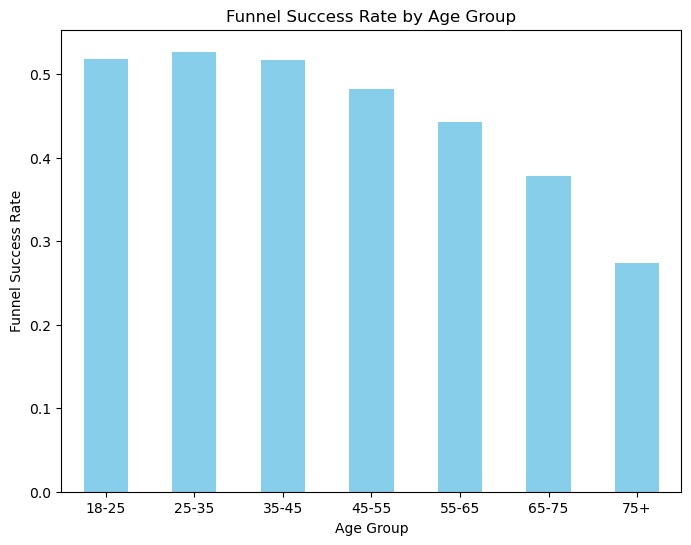

In [41]:
# Plotting the success rate by age group
plt.figure(figsize=(8,6))
age_success_rate.plot(kind='bar', color='skyblue')
plt.title('Funnel Success Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Funnel Success Rate')
plt.xticks(rotation=0)
plt.show()


In [42]:
# Recalculate the age bins with the new ranges provided
age_bins_new = pd.cut(df_unique_visits_by_client['age'], bins=[18, 25, 35, 45, 55, 65, 75, 100], labels=['18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75+'])

# Calculate the average time spent per visit_id for each age group
avg_time_spent_by_age_group = df_unique_visits_by_client.groupby(age_bins_new)['visit_duration_seconds'].mean()

# Display the average time spent by age group
avg_time_spent_by_age_group


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\3950567156.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_time_spent_by_age_group = df_unique_visits_by_client.groupby(age_bins_new)['visit_duration_seconds'].mean()


age
18-25    251.410465
25-35    249.293229
35-45    279.865470
45-55    334.206989
55-65    356.462481
65-75    350.051855
75+      354.506889
Name: visit_duration_seconds, dtype: float64

In [43]:
avg_time_spent_by_age_group.to_csv("avg_time_spent_by_age_group.csv")

In [44]:
# Recalculate the age bins with the new ranges provided
age_bins_new = pd.cut(df_unique_visits_by_client['age'], bins=[18, 25, 35, 45, 55, 65, 75, 100], labels=['18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75+'])

# Calculate the average time spent per visit_id for each age group and by Control vs Test groups
avg_time_spent_by_age_and_group = df_unique_visits_by_client.groupby([age_bins_new, 'variation'])['visit_duration_seconds'].mean()

# Display the result
avg_time_spent_by_age_and_group

C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\1612323392.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_time_spent_by_age_and_group = df_unique_visits_by_client.groupby([age_bins_new, 'variation'])['visit_duration_seconds'].mean()


age    variation
18-25  Control      220.537859
       Test         276.199161
25-35  Control      236.136899
       Test         259.824020
35-45  Control      260.190800
       Test         296.080081
45-55  Control      322.248165
       Test         343.380190
55-65  Control      324.777531
       Test         382.835743
65-75  Control      319.502397
       Test         375.768631
75+    Control      294.117419
       Test         402.905895
Name: visit_duration_seconds, dtype: float64

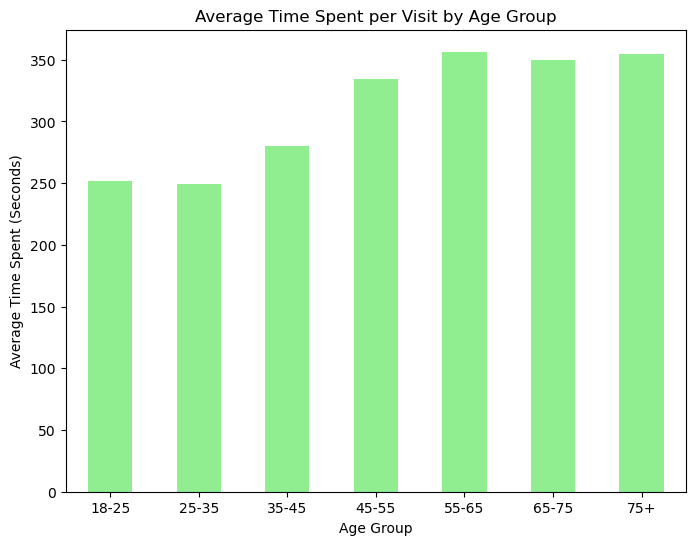

In [45]:
# Plotting the average time spent by age group
plt.figure(figsize=(8,6))
avg_time_spent_by_age_group.plot(kind='bar', color='lightgreen')
plt.title('Average Time Spent per Visit by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Time Spent (Seconds)')
plt.xticks(rotation=0)
plt.show()


In [46]:
# Analyze the impact of visit time on funnel success
# Group the data by funnel success and calculate the average visit duration for successful vs unsuccessful funnels
visit_time_success_impact = df_unique_visits_by_client.groupby('funnel_success')['visit_duration_seconds'].mean()

# Display the result
visit_time_success_impact


funnel_success
0    213.442501
1    422.995704
Name: visit_duration_seconds, dtype: float64

In [47]:
visit_time_success_impact.to_csv('visit_time_success_impact.csv')

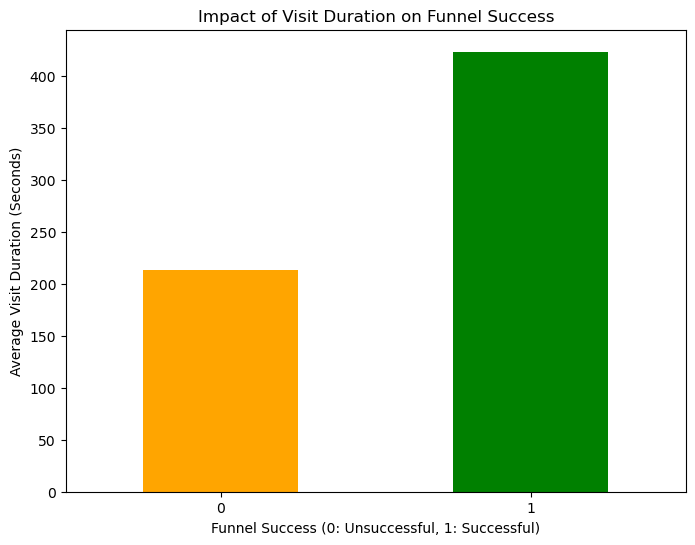

In [48]:
# Plotting the average visit duration for successful vs unsuccessful funnels
plt.figure(figsize=(8,6))
visit_time_success_impact.plot(kind='bar', color=['orange', 'green'])
plt.title('Impact of Visit Duration on Funnel Success')
plt.xlabel('Funnel Success (0: Unsuccessful, 1: Successful)')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.show()


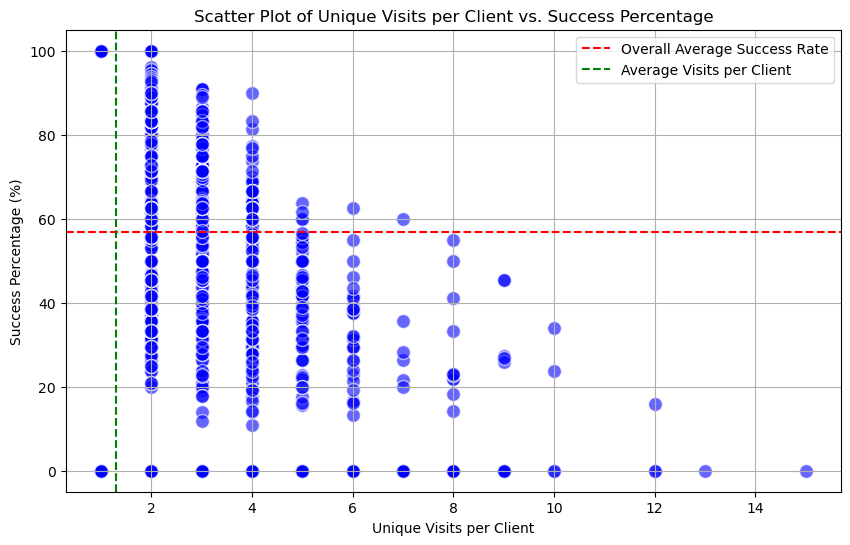

In [49]:
# Scatter plot of the average visits per client against the success rate for each client
plt.figure(figsize=(10, 6))
plt.scatter(success_percentage['unique_visit_ids'], success_percentage['success_percentage'], color='blue', s=100, alpha=0.6, edgecolors='w')
plt.axhline(average_success_rate, color='r', linestyle='--', label='Overall Average Success Rate')
plt.axvline(average_visits_per_client, color='g', linestyle='--', label='Average Visits per Client')
plt.title('Scatter Plot of Unique Visits per Client vs. Success Percentage')
plt.xlabel('Unique Visits per Client')
plt.ylabel('Success Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Step 1: Convert 'date_time' to datetime format
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# Step 2: Sort by client_id, visit_id, and date_time to ensure proper sequence
df = df.sort_values(by=['client_id', 'visit_id', 'date_time'], ignore_index=True)

# Step 3: Calculate 'time_spent' as the difference between consecutive steps within the same client and visit
df['next_date_time'] = df.groupby(['client_id', 'visit_id'])['date_time'].shift(-1)
df['time_spent'] = (df['next_date_time'] - df['date_time']).dt.total_seconds()

# Step 4: Remove rows where 'time_spent' is NaN, which indicates the last step in each sequence
df_steps_duration_corrected = df.dropna(subset=['time_spent'])

# Step 5: Remove the 'confirm' step, as it's the final step and shouldn't have a following step
df_steps_duration_corrected = df_steps_duration_corrected[df_steps_duration_corrected['process_step'] != 'confirm']

# Step 6: Recalculate the average time spent per step, grouped by 'variation' and 'process_step'
avg_step_duration_corrected = df_steps_duration_corrected.groupby(['variation', 'process_step'])['time_spent'].mean().reset_index()
avg_step_duration_corrected.rename(columns={'time_spent': 'avg_time_spent_seconds'}, inplace=True)

# Display the final corrected results
print(avg_step_duration_corrected)

  variation process_step  avg_time_spent_seconds
0   Control        start               68.900262
1   Control       step_1               47.337968
2   Control       step_2               92.559155
3   Control       step_3              143.655161
4      Test        start               60.200626
5      Test       step_1               62.049775
6      Test       step_2               88.366531
7      Test       step_3              131.994556


In [51]:
avg_step_duration_corrected.to_csv("avg_step_duration.csv")

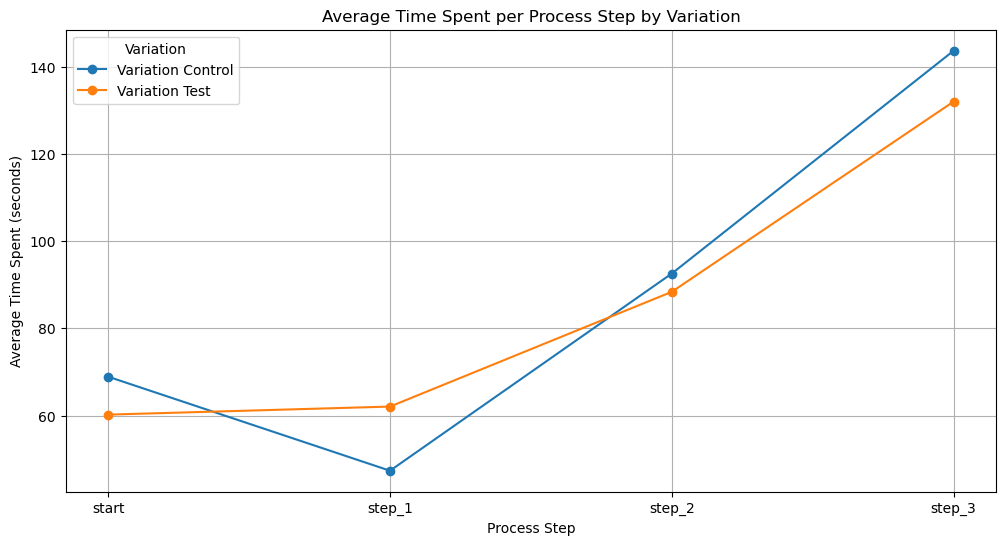

In [52]:
plt.figure(figsize=(12, 6))
for variation in avg_step_duration_corrected['variation'].unique():
    subset = avg_step_duration_corrected[avg_step_duration_corrected['variation'] == variation]
    plt.plot(subset['process_step'], subset['avg_time_spent_seconds'], marker='o', label=f'Variation {variation}')

plt.title('Average Time Spent per Process Step by Variation')
plt.xlabel('Process Step')
plt.ylabel('Average Time Spent (seconds)')
plt.legend(title='Variation')
plt.grid(True)
plt.show()

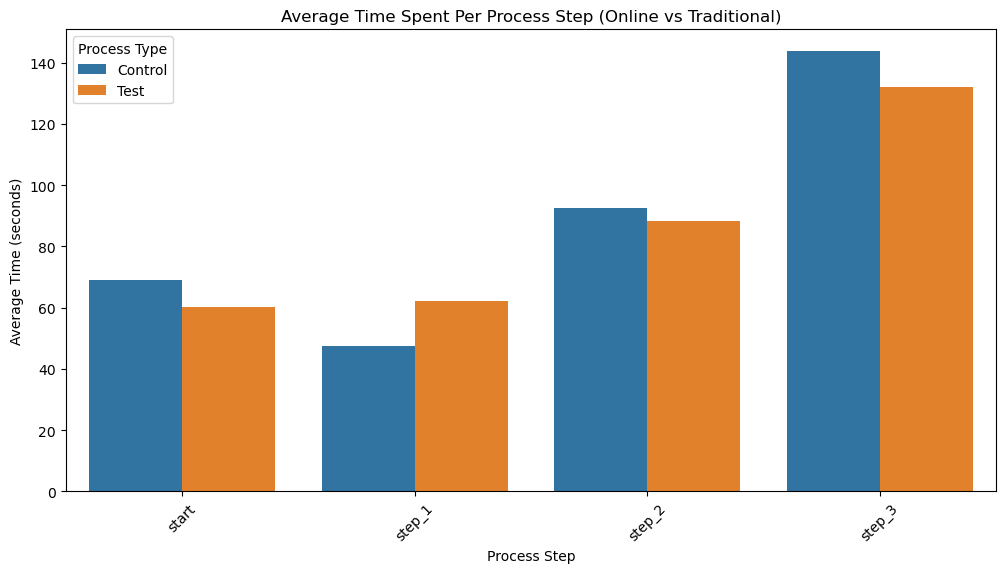

In [53]:
# Define the order for the process steps
order = ["start", "step_1", "step_2", "step_3"]

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the bar plot with the specified order
sns.barplot(
    data=avg_step_duration_corrected,
    x='process_step',
    y='avg_time_spent_seconds',
    hue='variation',
    order=order
)

# Customize the plot
plt.title("Average Time Spent Per Process Step (Online vs Traditional)")
plt.xlabel("Process Step")
plt.ylabel("Average Time (seconds)")
plt.legend(title="Process Type")
plt.xticks(rotation=45)

# Show the plot
plt.show()

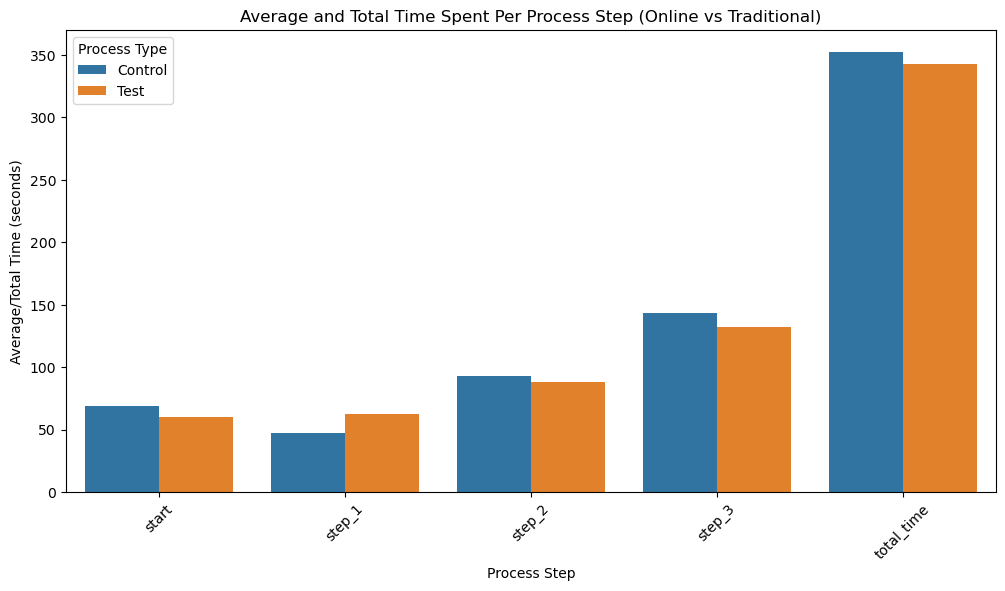

In [54]:
# Step 1: Calculate the cumulative time spent for each variation
total_time_spent = avg_step_duration_corrected.groupby('variation')['avg_time_spent_seconds'].sum().reset_index()
total_time_spent['process_step'] = 'total_time'

# Step 2: Append the total time to the original dataset
avg_step_duration_with_total = pd.concat([avg_step_duration_corrected, total_time_spent], ignore_index=True)

# Step 3: Define the order for the process steps, including the total time
order = ["start", "step_1", "step_2", "step_3", "total_time"]

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the bar plot with the specified order
sns.barplot(
    data=avg_step_duration_with_total,
    x='process_step',
    y='avg_time_spent_seconds',
    hue='variation',
    order=order
)

# Customize the plot
plt.title("Average and Total Time Spent Per Process Step (Online vs Traditional)")
plt.xlabel("Process Step")
plt.ylabel("Average/Total Time (seconds)")
plt.legend(title="Process Type")
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [55]:
total_clients = df.groupby('variation')['client_id'].nunique().reset_index()
total_clients.rename(columns={'client_id': 'total_clients'}, inplace=True)
# Step 2: Count unique clients reaching each step, grouped by variation and process step
clients_per_step = df.groupby(['variation', 'process_step'])['client_id'].nunique().reset_index()
clients_per_step.rename(columns={'client_id': 'clients_per_step'}, inplace=True)
# Step 3: Merge with the total clients to calculate the percentage reaching each step
clients_per_step = clients_per_step.merge(total_clients, on='variation')
clients_per_step['percentage_reaching_step'] = (clients_per_step['clients_per_step'] / clients_per_step['total_clients']) * 100
# Display the results
print(clients_per_step[['variation', 'process_step', 'percentage_reaching_step']])

  variation process_step  percentage_reaching_step
0   Control      confirm                 63.083671
1   Control        start                 99.628005
2   Control       step_1                 83.809894
3   Control       step_2                 77.835767
4   Control       step_3                 72.350230
5      Test      confirm                 68.285922
6      Test        start                 98.895756
7      Test       step_1                 89.907298
8      Test       step_2                 82.350268
9      Test       step_3                 77.060802


In [56]:
clients_per_step.to_csv("clients_per_step.csv")

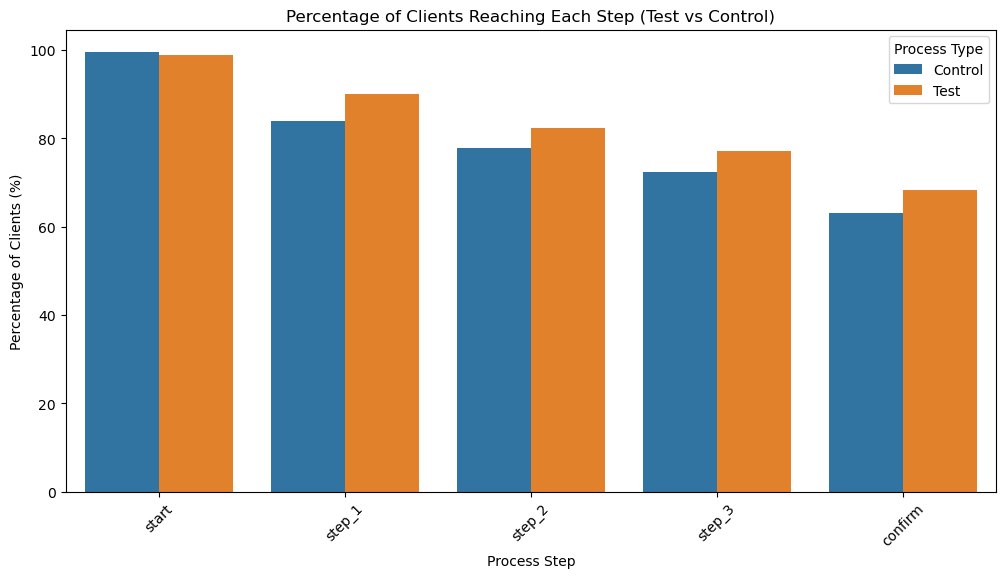

In [57]:
# Define the order for the process steps
order = ["start", "step_1", "step_2", "step_3", "confirm"]

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the bar plot with the specified order
sns.barplot(
    data=clients_per_step,
    x='process_step',
    y='percentage_reaching_step',
    hue='variation',
    order=order
)

# Customize the plot
plt.title("Percentage of Clients Reaching Each Step (Test vs Control)")
plt.xlabel("Process Step")
plt.ylabel("Percentage of Clients (%)")
plt.legend(title="Process Type")
plt.xticks(rotation=45)

# Show the plot
plt.show()

<Axes: xlabel='process_step', ylabel='percentage_reaching_step'>

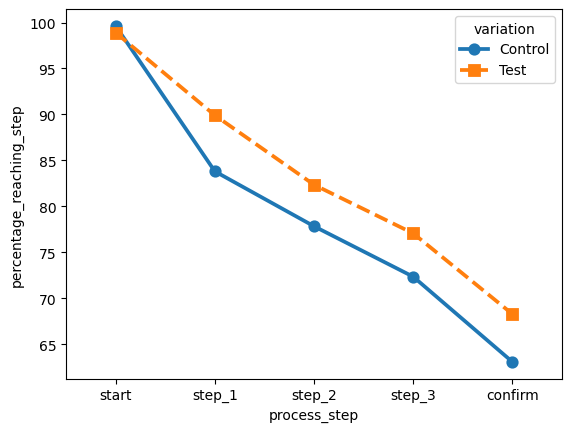

In [58]:
sns.pointplot(
    data=clients_per_step,
    x='process_step',
    y='percentage_reaching_step',
    hue='variation',
    order=order,
    markers=['o', 's'],  # Different markers for each variation
    linestyles=['-', '--'])  # Different line styles for variation

In [59]:
df_last = pd.read_csv("df_last.csv")

In [60]:
# Convert the 'date_time' column to datetime and clean the data
df['date_time'] = pd.to_datetime(df['date_time'])

# Remove duplicates to count one success/failure per unique visit_id
df_unique_visits_by_client = df.drop_duplicates(subset=['visit_id', 'client_id'], keep='first')

# Bin the tenure years into intervals (bins of 5 years for simplicity)
tenure_bins = pd.cut(df_unique_visits_by_client['tenure_year'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40], labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40'])

# Calculate the average funnel success rate for each tenure year bin
tenure_success_rate_binned = df_unique_visits_by_client.groupby(tenure_bins)['funnel_success'].mean()

# Display the result
tenure_success_rate_binned

C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\3036772938.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_success_rate_binned = df_unique_visits_by_client.groupby(tenure_bins)['funnel_success'].mean()


tenure_year
0-5      0.488891
5-10     0.483911
10-15    0.476710
15-20    0.439097
20-25    0.435851
25-30    0.395772
30-35    0.409483
35-40    0.394495
Name: funnel_success, dtype: float64

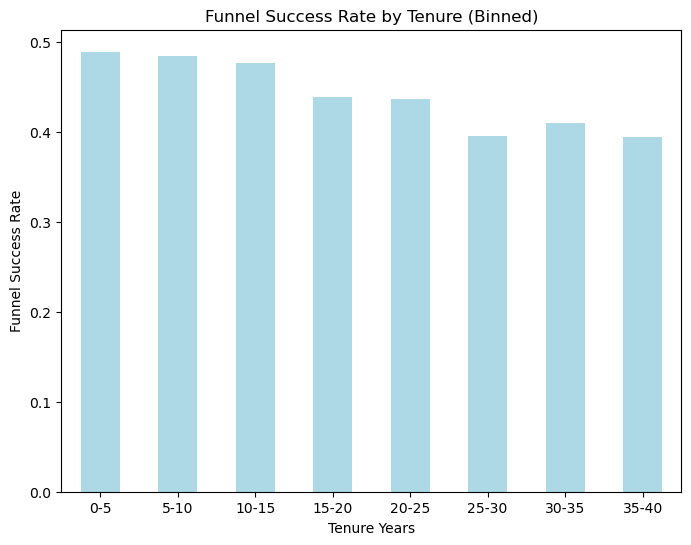

In [61]:
plt.figure(figsize=(8,6))
tenure_success_rate_binned.plot(kind='bar', color='lightblue')
plt.title('Funnel Success Rate by Tenure (Binned)')
plt.xlabel('Tenure Years')
plt.ylabel('Funnel Success Rate')
plt.xticks(rotation=0)
plt.show()

In [62]:
df_last = pd.read_csv("df_last.csv")

In [63]:
df_unique_visits = df_last.drop_duplicates(subset=['visit_id'], keep='first')

In [64]:
# Convert 'date_time' to a datetime format and create a new column indicating 'weekday' or 'weekend'
df_unique_visits['date_time'] = pd.to_datetime(df_unique_visits['date_time'], errors='coerce')

# Create a new column 'day_type' based on whether the visit occurred on a weekday or weekend
df_unique_visits['day_type'] = df_unique_visits['date_time'].dt.dayofweek.apply(lambda x: 'weekend' if x >= 5 else 'weekday')

# Group by 'variation' and 'day_type' and calculate the funnel success rate
funnel_success_summary = df_unique_visits.groupby(['variation', 'day_type'])['funnel_success'].mean() * 100

funnel_success_summary


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2785907958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_visits['date_time'] = pd.to_datetime(df_unique_visits['date_time'], errors='coerce')
C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2785907958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_visits['day_type'] = df_unique_visits['date_time'].dt.dayofweek.apply(lambda x: 'weekend' if x >= 5 else 'weekday')


variation  day_type
Control    weekday     45.095829
           weekend     40.120534
Test       weekday     49.621739
           weekend     45.612191
Name: funnel_success, dtype: float64

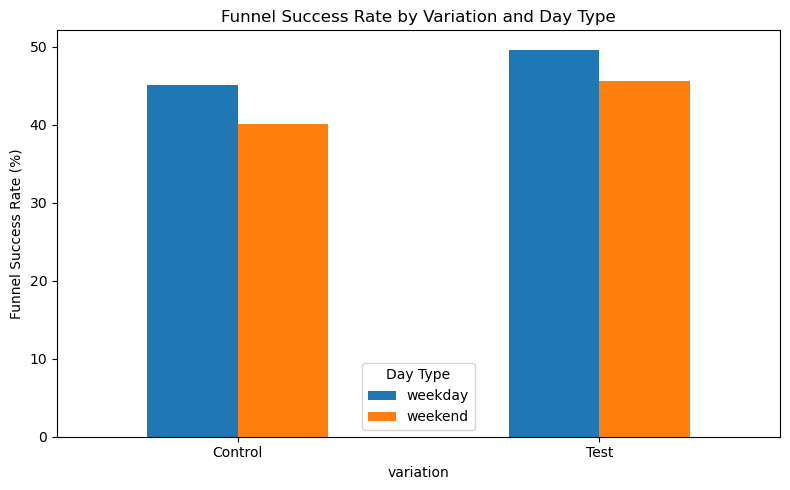

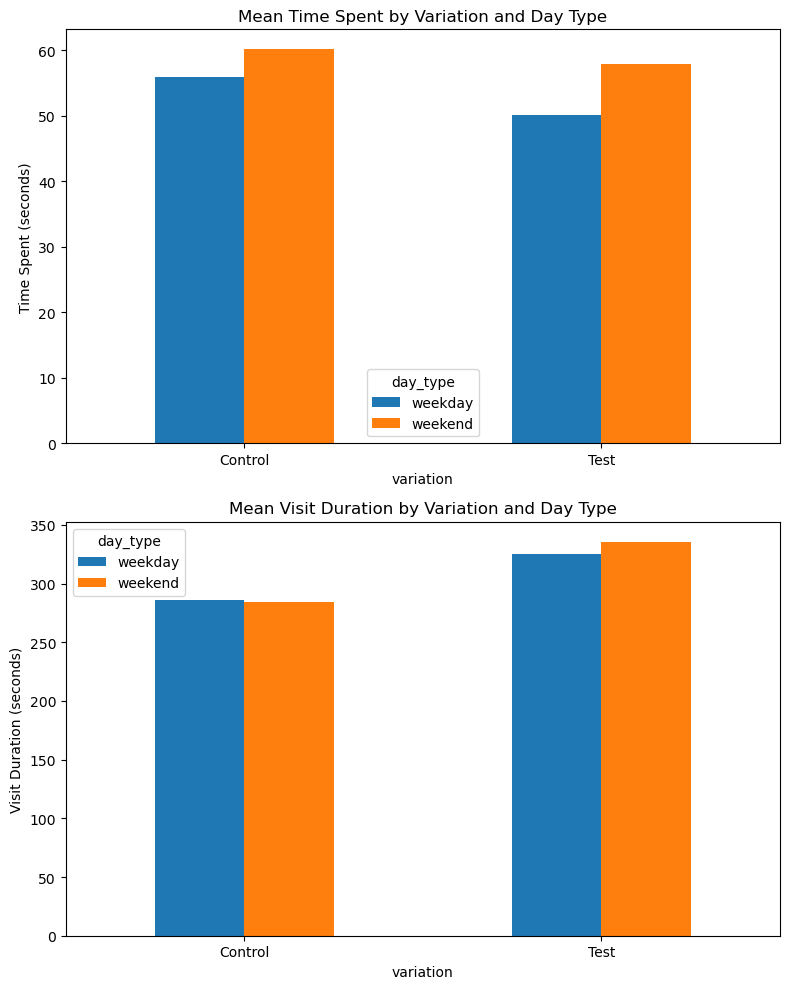

In [65]:
# Group by variation and day_type to calculate the mean and std of time spent and visit duration
time_spent_summary = df_unique_visits.groupby(['variation', 'day_type']).agg({
    'time_spent': ['mean', 'std'],
    'visit_duration_seconds': ['mean', 'std']
})

# Visualization 1: Funnel success rate comparison between Control and Test groups for weekday vs weekend
funnel_success_plot = funnel_success_summary.unstack().plot(kind='bar', figsize=(8, 5))
plt.title('Funnel Success Rate by Variation and Day Type')
plt.ylabel('Funnel Success Rate (%)')
plt.xticks(rotation=0)
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()

# Visualization 2: Mean time spent and visit duration comparison
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plotting mean time spent
time_spent_summary['time_spent']['mean'].unstack().plot(kind='bar', ax=axes[0])
axes[0].set_title('Mean Time Spent by Variation and Day Type')
axes[0].set_ylabel('Time Spent (seconds)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plotting mean visit duration
time_spent_summary['visit_duration_seconds']['mean'].unstack().plot(kind='bar', ax=axes[1])
axes[1].set_title('Mean Visit Duration by Variation and Day Type')
axes[1].set_ylabel('Visit Duration (seconds)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


In [66]:
df_unique_visits.to_csv("df_unique_visits_last.csv")

C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\3696895559.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  session_duration_funnel_correlation = df_unique_visits.groupby(['variation', 'day_type']).apply(


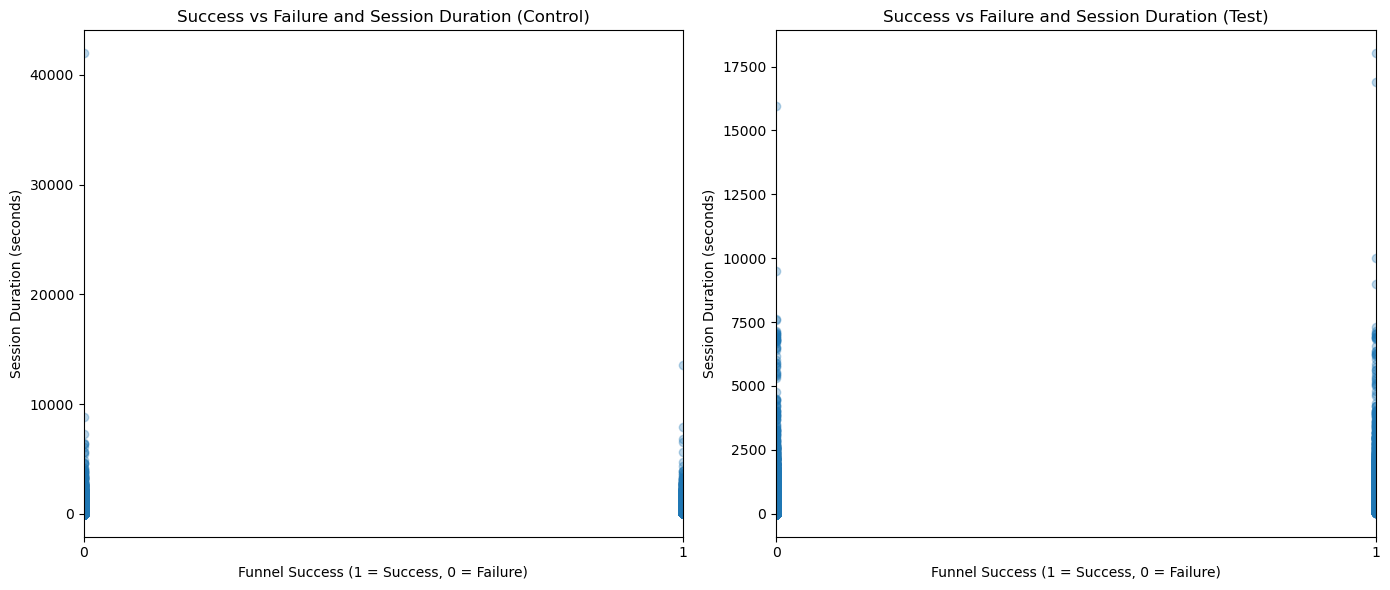

variation  day_type
Control    weekday     0.260481
           weekend     0.147776
Test       weekday     0.171776
           weekend     0.146703
dtype: float64

In [67]:
# Group the data by variation and day_type to calculate the correlation between visit_duration_seconds and funnel_success
session_duration_funnel_correlation = df_unique_visits.groupby(['variation', 'day_type']).apply(
    lambda x: x['visit_duration_seconds'].corr(x['funnel_success'].astype(float))
)
# Scatter plot: success/failure on x-axis, session duration on y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (variation, group_df) in enumerate(df_unique_visits.groupby('variation')):
    axes[idx].scatter(group_df['funnel_success'], group_df['visit_duration_seconds'], alpha=0.3)
    axes[idx].set_title(f'Success vs Failure and Session Duration ({variation})')
    axes[idx].set_xlabel('Funnel Success (1 = Success, 0 = Failure)')
    axes[idx].set_ylabel('Session Duration (seconds)')
    axes[idx].set_xlim([0, 1])  # Only show 0 and 1 values on the x-axis
    axes[idx].set_xticks([0, 1])

plt.tight_layout()
plt.show()



# Display the correlation between session duration and funnel success
session_duration_funnel_correlation


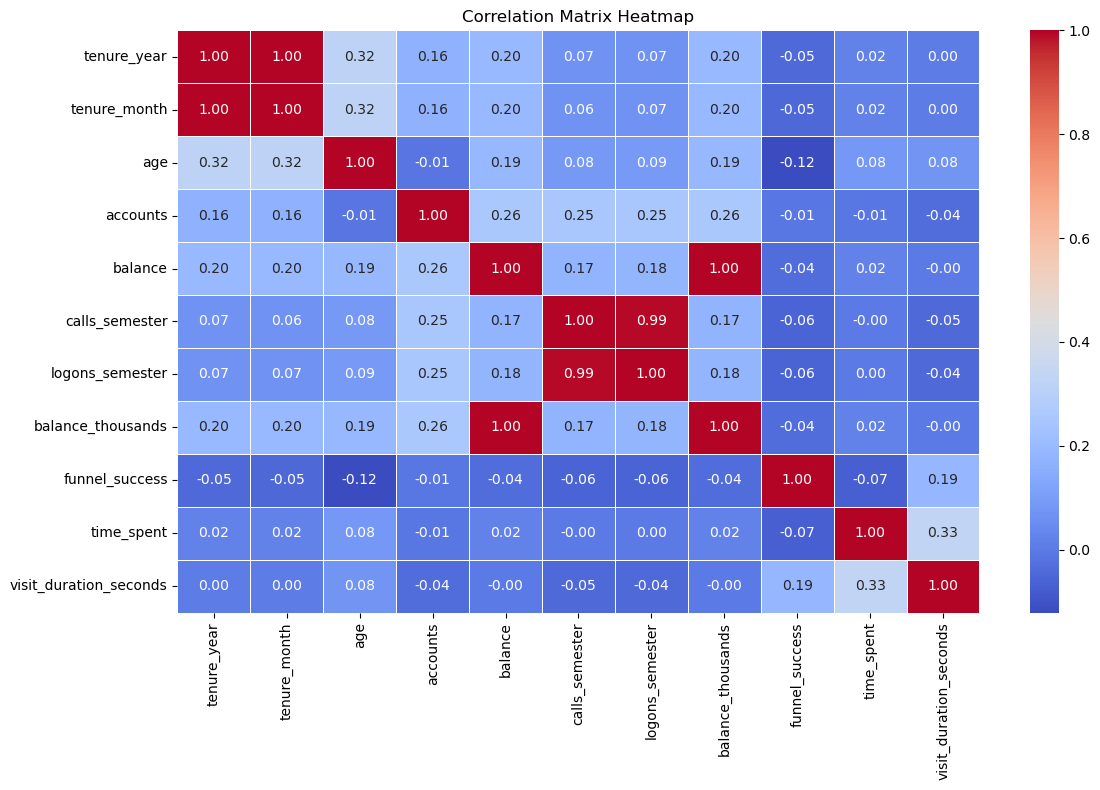

In [68]:




df_cleaned = df_unique_visits.drop(columns=[col for col in df_unique_visits.columns if 'Unnamed' in col or 'client_id' in col])

# Calculate the correlation matrix again without these columns
correlation_matrix_cleaned = df_cleaned.corr(numeric_only=True)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


In [69]:
from scipy import stats

# Define the null hypothesis (H0): The completion rate difference between Test and Control is not statistically significant.
# Alternative hypothesis (H1): The completion rate difference between Test and Control is statistically significant.

# First, calculate the completion rate for both the Control and Test groups
completion_rate_control = df_unique_visits[df_unique_visits['variation'] == 'Control']['funnel_success'].mean()
completion_rate_test = df_unique_visits[df_unique_visits['variation'] == 'Test']['funnel_success'].mean()

# Calculate the total sample size for each group
n_control = df_unique_visits[df_unique_visits['variation'] == 'Control'].shape[0]
n_test = df_unique_visits[df_unique_visits['variation'] == 'Test'].shape[0]

# Perform a two-proportion z-test to compare the completion rates
success_control = df_unique_visits[df_unique_visits['variation'] == 'Control']['funnel_success'].sum()
success_test = df_unique_visits[df_unique_visits['variation'] == 'Test']['funnel_success'].sum()

# Proportions
p_control = completion_rate_control
p_test = completion_rate_test

# Pooled proportion
p_pool = (success_control + success_test) / (n_control + n_test)

# Standard error
se = ((p_pool * (1 - p_pool)) * (1/n_control + 1/n_test)) ** 0.5

# Z score
z_score = (p_test - p_control) / se

# p-value
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test

# Now test the threshold (5% increase in completion rate)
threshold = 0.05
effect_size = p_test - p_control
meets_threshold = effect_size >= threshold

# Significance level
alpha = 0.05

# Display the results to the user
{
    "Completion Rate (Control)": p_control,
    "Completion Rate (Test)": p_test,
    "Z-Score": z_score,
    "P-Value": p_value,
    "Statistically Significant": p_value < alpha,
    "Meets Cost-Effectiveness Threshold (5%)": meets_threshold
}


{'Completion Rate (Control)': 0.44102608172560476,
 'Completion Rate (Test)': 0.4882441046361768,
 'Z-Score': 10.72972275273098,
 'P-Value': 0.0,
 'Statistically Significant': True,
 'Meets Cost-Effectiveness Threshold (5%)': False}

In [70]:
# Let's first segment the data by age group and perform the hypothesis testing (like before) but for each age group.

# Define the age groups
age_groups = df_unique_visits['age_group'].unique()

# Initialize results container
age_group_results = {}

# Loop over each age group and perform the same test
for age_group in age_groups:
    # Filter data by age group
    age_group_data = df_unique_visits[df_unique_visits['age_group'] == age_group]
    
    # Completion rates for Control and Test in the age group
    completion_rate_control_age = age_group_data[age_group_data['variation'] == 'Control']['funnel_success'].mean()
    completion_rate_test_age = age_group_data[age_group_data['variation'] == 'Test']['funnel_success'].mean()
    
    # Sample sizes
    n_control_age = age_group_data[age_group_data['variation'] == 'Control'].shape[0]
    n_test_age = age_group_data[age_group_data['variation'] == 'Test'].shape[0]
    
    # Successes
    success_control_age = age_group_data[age_group_data['variation'] == 'Control']['funnel_success'].sum()
    success_test_age = age_group_data[age_group_data['variation'] == 'Test']['funnel_success'].sum()
    
    # Pooled proportion
    p_pool_age = (success_control_age + success_test_age) / (n_control_age + n_test_age)
    
    # Standard error
    se_age = ((p_pool_age * (1 - p_pool_age)) * (1/n_control_age + 1/n_test_age)) ** 0.5
    
    # Z score
    z_score_age = (completion_rate_test_age - completion_rate_control_age) / se_age
    
    # p-value
    p_value_age = 2 * (1 - stats.norm.cdf(abs(z_score_age)))  # Two-tailed test
    
    # Threshold check
    effect_size_age = completion_rate_test_age - completion_rate_control_age
    meets_threshold_age = effect_size_age >= threshold
    
    # Store results for this age group
    age_group_results[age_group] = {
        "Completion Rate (Control)": completion_rate_control_age,
        "Completion Rate (Test)": completion_rate_test_age,
        "Z-Score": z_score_age,
        "P-Value": p_value_age,
        "Statistically Significant": p_value_age < alpha,
        "Meets Cost-Effectiveness Threshold (5%)": meets_threshold_age
    }

# Convert results to a DataFrame for easier display
age_group_results_df = pd.DataFrame(age_group_results).T

age_group_results_df


,Completion Rate (Control),Completion Rate (Test),Z-Score,P-Value,Statistically Significant,Meets Cost-Effectiveness Threshold (5%)
18-35,0.482095,0.555841,8.466529,0.0,True,True
50-65,0.430294,0.46365,4.404767,0.000011,True,False
35-50,0.482494,0.531792,5.485867,0.0,True,False
65+,0.341382,0.36788,2.550236,0.010765,True,False
<18,0.384615,0.462687,0.907342,0.364226,False,True


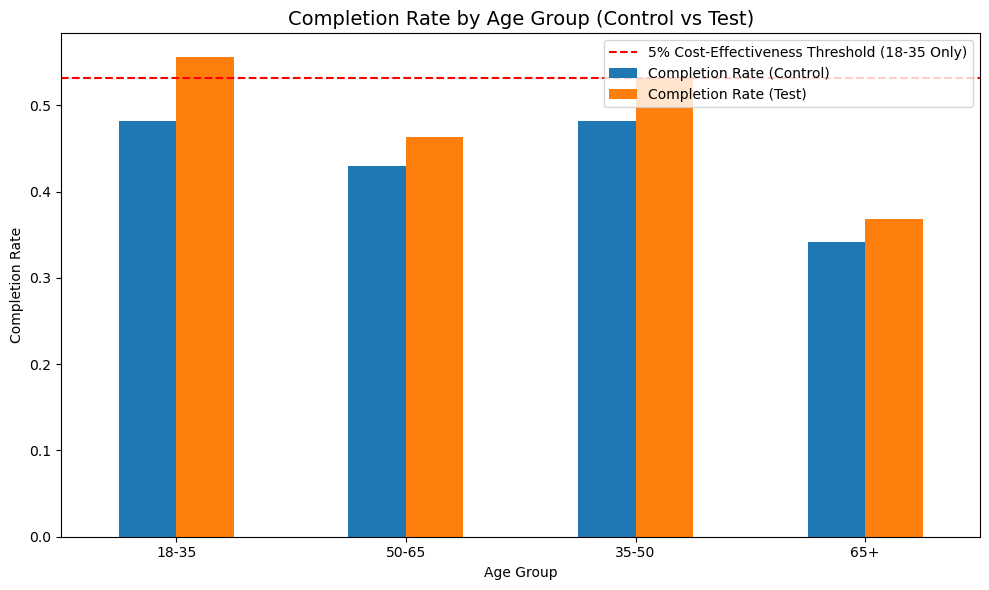

In [71]:
# Filter out the '<18' age group for visualization
age_group_results_filtered = age_group_results_df.drop('<18')

# Plotting the Completion Rate difference between Test and Control by Age Group
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Completion Rate for Control and Test
age_group_results_filtered[['Completion Rate (Control)', 'Completion Rate (Test)']].plot(kind='bar', ax=ax)

# Add a horizontal line only for the 18-35 age group, showing the 5% cost-effectiveness threshold
threshold_line_position = age_group_results_filtered.loc['18-35', 'Completion Rate (Control)'] + 0.05
ax.axhline(y=threshold_line_position, color='r', linestyle='--', label='5% Cost-Effectiveness Threshold (18-35 Only)')

# Add title and labels
ax.set_title('Completion Rate by Age Group (Control vs Test)', fontsize=14)
ax.set_ylabel('Completion Rate')
ax.set_xlabel('Age Group')
plt.xticks(rotation=0)

# Show the legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()



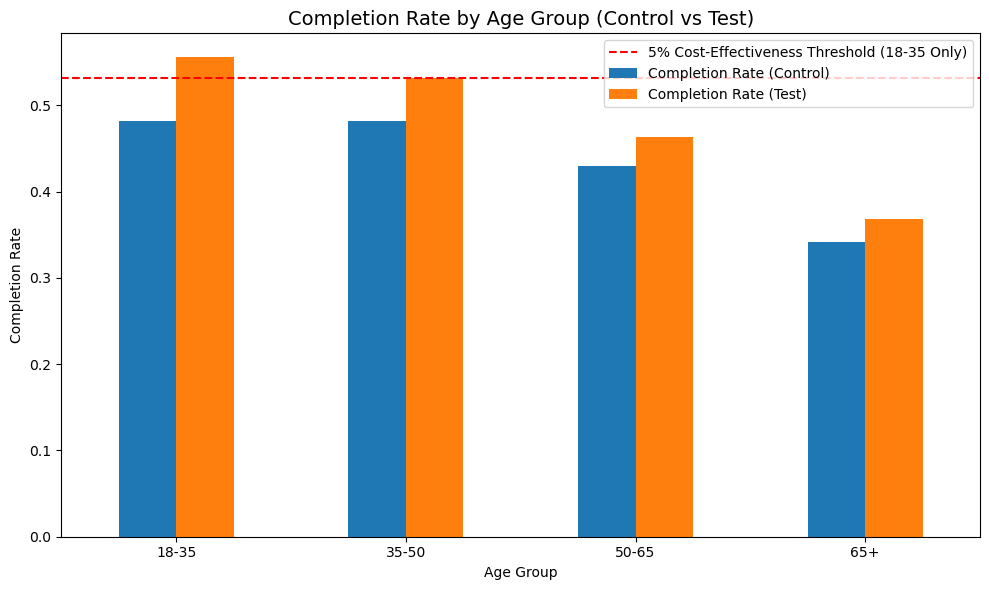

In [72]:
# Sort the age group results by age in ascending order
age_group_results_filtered_sorted = age_group_results_filtered.sort_index()

age_group_results_filtered_sorted

# Plotting the Completion Rate difference between Test and Control by Age Group (in ascending order)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Completion Rate for Control and Test
age_group_results_filtered_sorted[['Completion Rate (Control)', 'Completion Rate (Test)']].plot(kind='bar', ax=ax)

# Add a horizontal line for the 18-35 age group, showing the 5% cost-effectiveness threshold
threshold_line_position_sorted = age_group_results_filtered_sorted.loc['18-35', 'Completion Rate (Control)'] + 0.05
ax.axhline(y=threshold_line_position_sorted, color='r', linestyle='--', label='5% Cost-Effectiveness Threshold (18-35 Only)')

# Add title and labels
ax.set_title('Completion Rate by Age Group (Control vs Test)', fontsize=14)
ax.set_ylabel('Completion Rate')
ax.set_xlabel('Age Group')
plt.xticks(rotation=0)

# Show the legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()



In [73]:
from scipy.stats import chi2_contingency
# Let's bin the 'balance' column as requested into bins of 50000 up to 500000, with a final bin for 500000+
bins = list(range(0, 550000, 50000))  # Create bins from 0 to 500000
bins.append(float('inf'))  # Add a final bin for 500000+

# Bin the balance column
df_unique_visits['balance_binned'] = pd.cut(df_unique_visits['balance'], bins=bins, labels=[f"{i}-{i+50000}" for i in range(0, 500000, 50000)] + ['500000+'])

# Now let's do hypothesis testing to determine if account balance and funnel success are related for Test vs Control

# Separate the data into Test and Control groups
test_group = df_unique_visits[df_unique_visits['variation'] == 'Test']
control_group = df_unique_visits[df_unique_visits['variation'] == 'Control']

# Create contingency tables for Test and Control groups
test_contingency = pd.crosstab(test_group['balance_binned'], test_group['funnel_success'])
control_contingency = pd.crosstab(control_group['balance_binned'], control_group['funnel_success'])

# Apply the chi-squared test to both
test_stat, test_p, test_dof, test_expected = chi2_contingency(test_contingency)
control_stat, control_p, control_dof, control_expected = chi2_contingency(control_contingency)

test_p, control_p  # Output p-values for both tests

# Now let's perform a chi-squared test for each $50,000 bin, with the last category being 500,000+,
# comparing funnel success between Test and Control variations in each bin.

# First, we will create contingency tables for each bin comparing Test and Control variations.

# Group by the balance bins and variation
contingency_tables = pd.crosstab(df_unique_visits['balance_binned'], df_unique_visits['variation'], df_unique_visits['funnel_success'], aggfunc='sum')

# Perform a chi-squared test for each balance bin (we will loop through each bin)
results = {}

for balance_bin in contingency_tables.index:
    # Contingency table for the specific balance bin
    bin_contingency = pd.crosstab(df_unique_visits[df_unique_visits['balance_binned'] == balance_bin]['variation'],
                                  df_unique_visits[df_unique_visits['balance_binned'] == balance_bin]['funnel_success'])
    
    # Apply the chi-squared test
    stat, p, dof, expected = chi2_contingency(bin_contingency)
    
    # Store the result
    results[balance_bin] = {'p_value': p, 'chi2_stat': stat}

# Convert results to a DataFrame and display it
results_df = pd.DataFrame(results).T

results_df


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\3762928924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_visits['balance_binned'] = pd.cut(df_unique_visits['balance'], bins=bins, labels=[f"{i}-{i+50000}" for i in range(0, 500000, 50000)] + ['500000+'])


,p_value,chi2_stat
0-50000,2.010287e-13,53.994724
50000-100000,1.599563e-09,36.409080
100000-150000,2.168919e-06,22.439286
150000-200000,2.096274e-02,5.329887
200000-250000,3.724638e-01,0.795428
250000-300000,3.458918e-02,4.465341
300000-350000,6.402154e-01,0.218461
350000-400000,4.776688e-01,0.504181
400000-450000,5.905915e-03,7.578788
450000-500000,4.974399e-01,0.460394


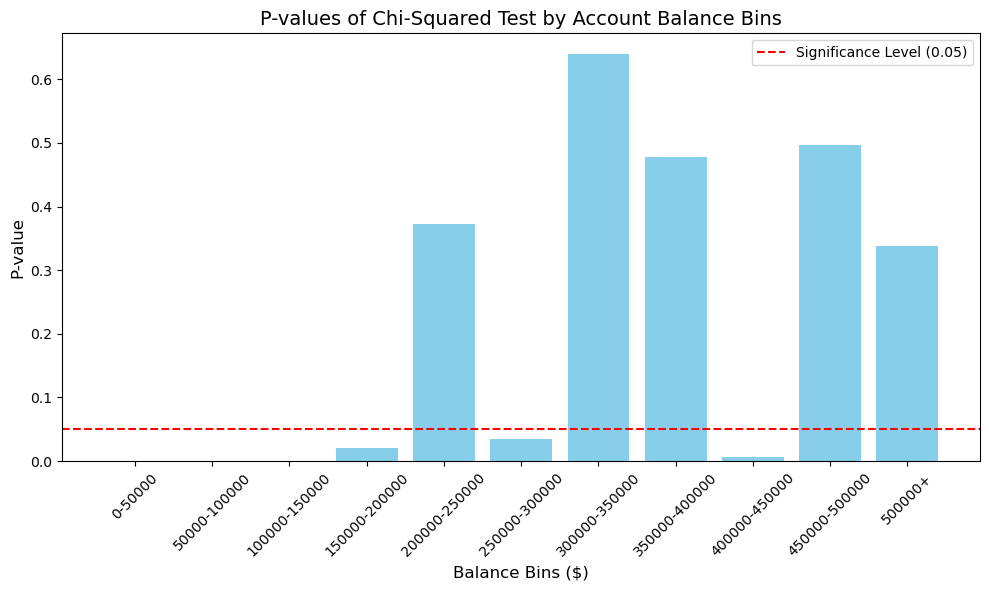

In [74]:


# Visualize the p-values across the balance bins
plt.figure(figsize=(10,6))

# Plot p-values
plt.bar(results_df.index, results_df['p_value'], color='skyblue')

# Add significant line
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')

plt.title('P-values of Chi-Squared Test by Account Balance Bins', fontsize=14)
plt.xlabel('Balance Bins ($)', fontsize=12)
plt.ylabel('P-value', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2964075816.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_rates = df_unique_visits.groupby(['balance_binned', 'variation'])['funnel_success'].mean().unstack()


<function matplotlib.pyplot.show(close=None, block=None)>

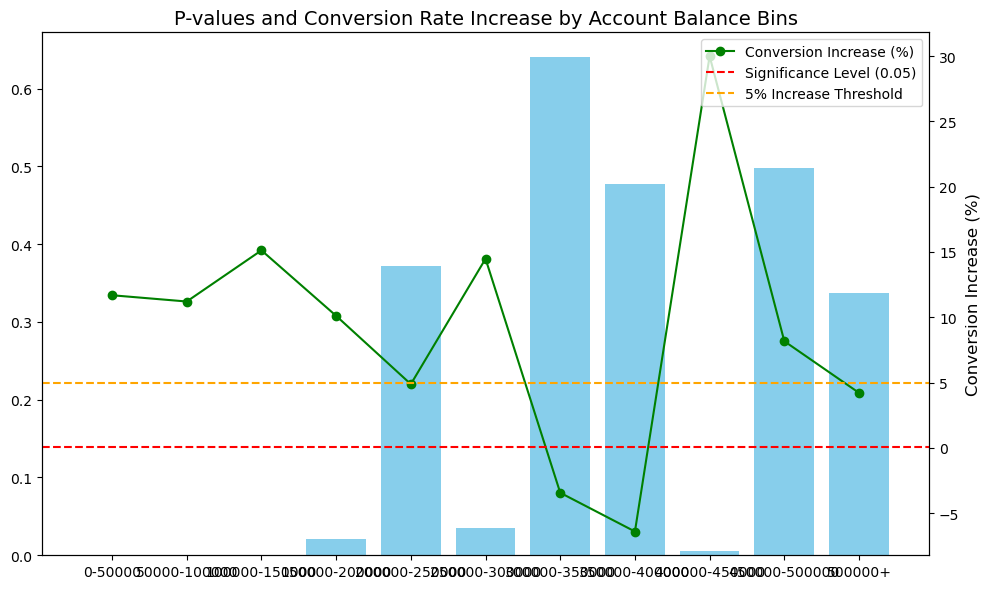

In [75]:
# Let's first calculate the conversion rates (funnel_success) for both Test and Control groups in each balance bin
conversion_rates = df_unique_visits.groupby(['balance_binned', 'variation'])['funnel_success'].mean().unstack()

# Now, calculate the relative increase in conversion for Test vs Control
conversion_rates['increase_%'] = (conversion_rates['Test'] - conversion_rates['Control']) / conversion_rates['Control'] * 100

# We will now modify the previous plot to include this information and the 5% threshold.

plt.figure(figsize=(10,6))

# Plot p-values
plt.bar(results_df.index, results_df['p_value'], color='skyblue', label='P-value')

# Plot conversion increase percentage on secondary axis
ax2 = plt.twinx()
ax2.plot(conversion_rates.index, conversion_rates['increase_%'], color='green', marker='o', label='Conversion Increase (%)')

# Add significant line for p-value
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')

# Add threshold for the 5% increase in conversion
ax2.axhline(y=5, color='orange', linestyle='--', label='5% Increase Threshold')

# Labels and legends
plt.title('P-values and Conversion Rate Increase by Account Balance Bins', fontsize=14)
plt.xlabel('Balance Bins ($)', fontsize=12)
plt.ylabel('P-value', fontsize=12)
ax2.set_ylabel('Conversion Increase (%)', fontsize=12)
plt.xticks(rotation=90)

plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show


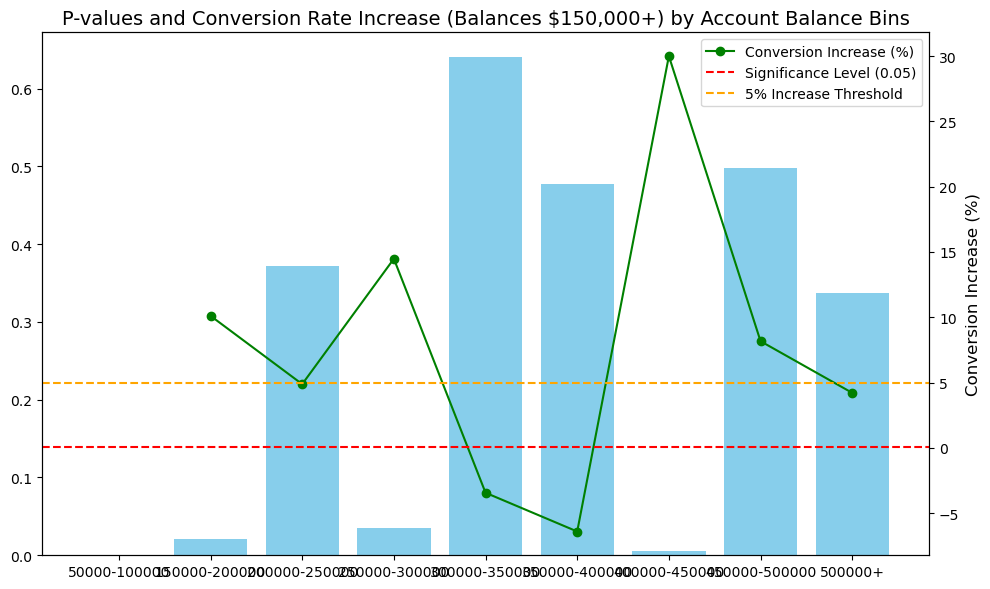

In [76]:
# Filter out bins below 150000
filtered_conversion_rates = conversion_rates.loc[conversion_rates.index >= "150000-200000"]
filtered_results_df = results_df.loc[results_df.index >= "150000-200000"]

plt.figure(figsize=(10,6))

# Plot p-values for filtered data
plt.bar(filtered_results_df.index, filtered_results_df['p_value'], color='skyblue', label='P-value')

# Plot conversion increase percentage on secondary axis
ax2 = plt.twinx()
ax2.plot(filtered_conversion_rates.index, filtered_conversion_rates['increase_%'], color='green', marker='o', label='Conversion Increase (%)')

# Add significant line for p-value
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')

# Add threshold for the 5% increase in conversion
ax2.axhline(y=5, color='orange', linestyle='--', label='5% Increase Threshold')

# Labels and legends
plt.title('P-values and Conversion Rate Increase (Balances $150,000+) by Account Balance Bins', fontsize=14)
plt.xlabel('Balance Bins ($)', fontsize=12)
plt.ylabel('P-value', fontsize=12)
ax2.set_ylabel('Conversion Increase (%)', fontsize=12)
plt.xticks(rotation=30)

plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [77]:
from scipy.stats import ttest_ind

# Drop rows with missing ages to ensure valid analysis
test_age_group = df_unique_visits[(df_unique_visits['variation'] == 'Test') & (df_unique_visits['age'].notna())]['age']
control_age_group = df_unique_visits[(df_unique_visits['variation'] == 'Control') & (df_unique_visits['age'].notna())]['age']

# Perform a two-sample t-test to compare the average ages
t_stat, p_value = ttest_ind(test_age_group, control_age_group, equal_var=False)  # Assume unequal variance

t_stat, p_value  # Output the test statistic and p-value


(-1.1946859394889908, 0.232215456656351)

In [78]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Prepare the data for two-way ANOVA to explore the interaction between variation (Test/Control) and account balance
# We will use 'balance_binned' as the categorical variable representing account balance and 'variation' as the other factor
# The dependent variable will be 'funnel_success'

# Drop rows with missing data in the relevant columns
anova_data = df_unique_visits[['balance_binned', 'variation', 'funnel_success']].dropna()

# Fit the two-way ANOVA model with interaction term
model = ols('funnel_success ~ C(variation) * C(balance_binned)', data=anova_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table


,sum_sq,df,F,PR(>F)
C(variation),28.919776,1.0,116.975423,3.107430e-27
C(balance_binned),59.988563,10.0,24.264322,2.485353e-46
C(variation):C(balance_binned),4.557107,10.0,1.843270,4.811644e-02
Residual,12846.045013,51960.0,NaN,NaN


In [79]:
from statsmodels.stats.proportion import proportions_ztest

# Create a list to store the results for each balance bin
balance_bin_results = []

# Loop over each unique balance bin
for balance_bin in df_unique_visits['balance_binned'].unique():
    # Filter the data for the current balance bin
    bin_data = df_unique_visits[df_unique_visits['balance_binned'] == balance_bin]
    
    # Get the counts of funnel success in Test and Control groups
    success_counts = bin_data.groupby('variation')['funnel_success'].sum()
    n_counts = bin_data.groupby('variation')['funnel_success'].count()
    
    # Perform a z-test for proportions comparing Test vs Control
    count = [success_counts['Test'], success_counts['Control']]
    nobs = [n_counts['Test'], n_counts['Control']]
    
    z_stat, p_val = proportions_ztest(count, nobs)
    
    # Store the results
    balance_bin_results.append({
        'balance_bin': balance_bin,
        'z_stat': z_stat,
        'p_value': p_val
    })

# Convert results into a DataFrame for display
balance_bin_results_df = pd.DataFrame(balance_bin_results)


balance_bin_results_df


,balance_bin,z_stat,p_value
0,0-50000,7.363112,1.796716e-13
1,100000-150000,4.762972,1.907624e-06
2,150000-200000,2.344510,1.905209e-02
3,50000-100000,6.050675,1.442400e-09
4,500000+,0.994170,3.201403e-01
5,200000-250000,0.936145,3.491985e-01
6,300000-350000,-0.528034,5.974758e-01
7,250000-300000,2.166143,3.030027e-02
8,400000-450000,2.828430,4.677700e-03
9,450000-500000,0.765659,4.438794e-01


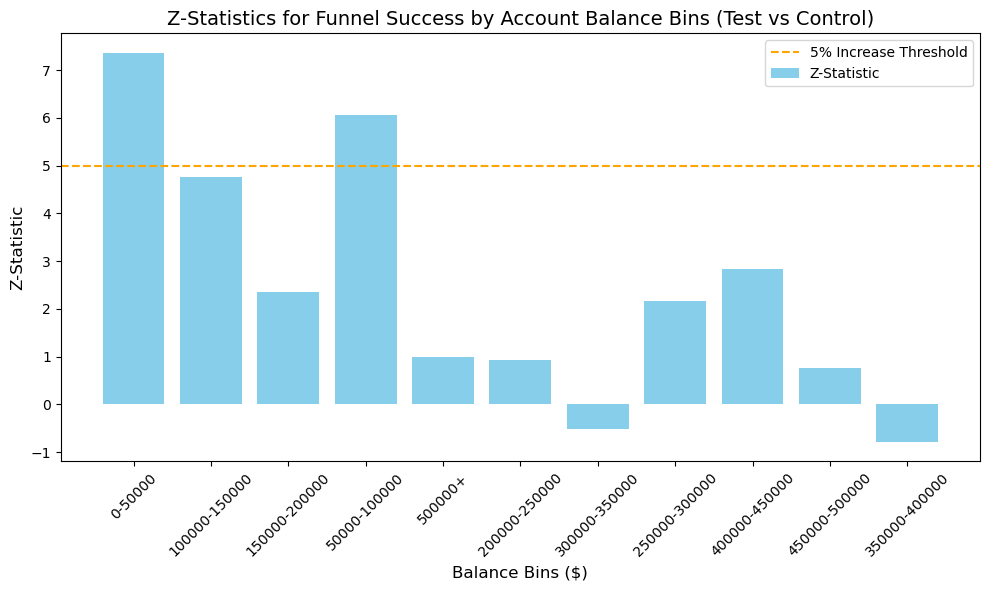

In [80]:
# Prepare the data for visualization
balance_bin_results_df['conversion_increase'] = (balance_bin_results_df['z_stat'] > 0) * 5  # Assume 5% threshold if z_stat is positive

plt.figure(figsize=(10,6))

# Bar plot for z-statistics (test vs control difference in conversion)
plt.bar(balance_bin_results_df['balance_bin'], balance_bin_results_df['z_stat'], color='skyblue', label='Z-Statistic')

# Add a threshold line for 5% increase in conversion
plt.axhline(y=5, color='orange', linestyle='--', label='5% Increase Threshold')

plt.title('Z-Statistics for Funnel Success by Account Balance Bins (Test vs Control)', fontsize=14)
plt.xlabel('Balance Bins ($)', fontsize=12)
plt.ylabel('Z-Statistic', fontsize=12)
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


In [81]:
# Calculate the proportion of users in each balance bin
total_users = len(df_unique_visits)
balance_bin_proportions = df_unique_visits['balance_binned'].value_counts() / total_users

# Assume that a positive z-statistic represents a >= 5% conversion increase, for simplicity
balance_bin_results_df['conversion_success'] = (balance_bin_results_df['z_stat'] > 0) * 5  # Assume 5% threshold

# Join the proportion data with the z-test results
balance_bin_results_df['proportion'] = balance_bin_results_df['balance_bin'].map(balance_bin_proportions)

# Calculate weighted conversion success (proportion * conversion increase)
balance_bin_results_df['weighted_success'] = balance_bin_results_df['conversion_success'] * balance_bin_results_df['proportion']

# Calculate the overall success by summing the weighted successes
overall_success = balance_bin_results_df['weighted_success'].sum()

balance_bin_results_df[['balance_bin', 'proportion', 'conversion_success', 'weighted_success']], overall_success


(      balance_bin  proportion  conversion_success  weighted_success
 0         0-50000    0.346004                   5          1.730022
 1   100000-150000    0.117194                   5          0.585972
 2   150000-200000    0.061925                   5          0.309626
 3    50000-100000    0.279443                   5          1.397214
 4         500000+    0.064215                   5          0.321073
 5   200000-250000    0.040937                   5          0.204686
 6   300000-350000    0.021296                   0          0.000000
 7   250000-300000    0.028606                   5          0.143030
 8   400000-450000    0.014216                   5          0.071082
 9   450000-500000    0.010658                   5          0.053288
 10  350000-400000    0.015505                   0          0.000000,
 4.815993997922358)

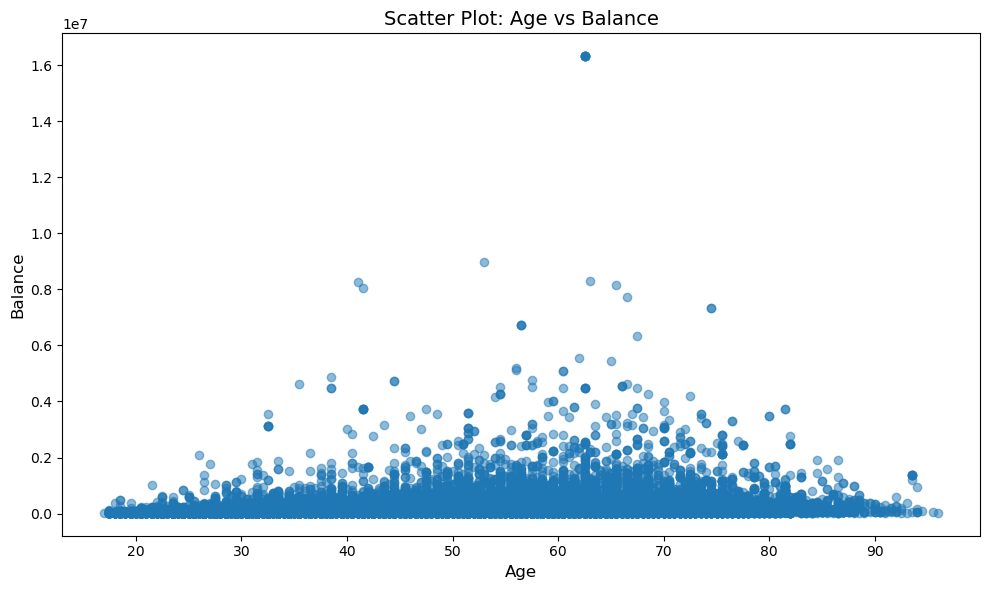

(0.19323961218771377, 0.0)

In [83]:
# Let's calculate the correlation between 'age' and 'balance'
from scipy.stats import pearsonr

# First, we will drop rows with missing values in either 'age' or 'balance'
df_age_balance_clean = df_unique_visits[['age', 'balance']].dropna()

# Calculate the correlation coefficient
age_balance_correlation = df_age_balance_clean['age'].corr(df_age_balance_clean['balance'])

# Perform a hypothesis test for the correlation (using Pearson correlation)
age_balance_corr_stat, age_balance_p_value = pearsonr(df_age_balance_clean['age'], df_age_balance_clean['balance'])

# Visualize the relationship between age and balance with a scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df_age_balance_clean['age'], df_age_balance_clean['balance'], alpha=0.5)
plt.title('Scatter Plot: Age vs Balance', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Balance', fontsize=12)
plt.tight_layout()
plt.show()

age_balance_correlation, age_balance_p_value  # Display the correlation coefficient and p-value


In [88]:
# Let's create age bins and calculate the correlation between age and balance within each bin.
# We will categorize the age into bins and then calculate the correlation for each bin.

# Define the age bins
bins = [18, 30, 40, 50, 60, 70, 80, 100]
df_unique_visits['age_bin'] = pd.cut(df_unique_visits['age'], bins)

# Group by age bins and calculate the correlation within each group
age_bin_corr = df_unique_visits.groupby('age_bin').apply(
    lambda x: x['age'].corr(x['balance_thousands'])
)

# Display the correlations for each age bin
age_bin_corr


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\1021554480.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_visits['age_bin'] = pd.cut(df_unique_visits['age'], bins)
C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\1021554480.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bin_corr = df_unique_visits.groupby('age_bin').apply(
C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\1021554480.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

age_bin
(18, 30]     0.115624
(30, 40]     0.072680
(40, 50]     0.026113
(50, 60]     0.005634
(60, 70]     0.012491
(70, 80]     0.019462
(80, 100]   -0.049762
dtype: float64

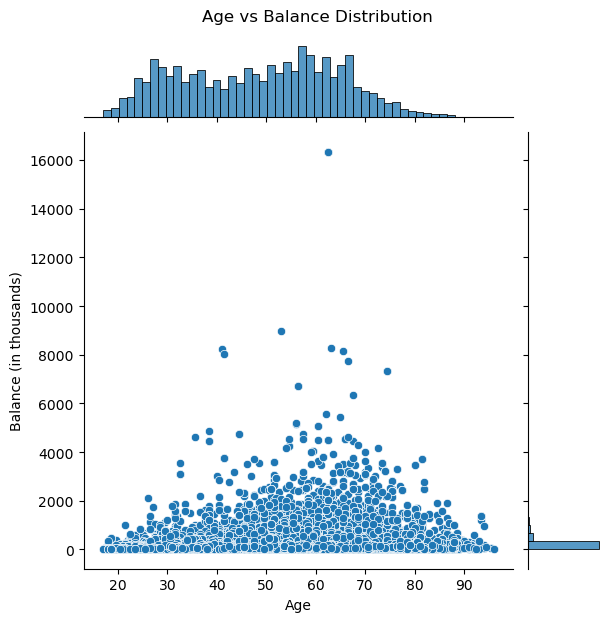

In [89]:

# Create a jointplot to show the distribution of age and balance along with a scatter plot
sns.jointplot(x='age', y='balance_thousands', data=df_unique_visits, kind='scatter', marginal_kws=dict(bins=50, fill=True))

plt.suptitle('Age vs Balance Distribution', y=1.03)
plt.xlabel('Age')
plt.ylabel('Balance (in thousands)')
plt.show()


In [92]:
# Group by age bins and calculate the average balance per age group
average_balance_per_age_group = df_unique_visits.groupby('age_bin')['balance_thousands'].mean()

average_balance_per_age_group

C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2301982519.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_balance_per_age_group = df_unique_visits.groupby('age_bin')['balance_thousands'].mean()


age_bin
(18, 30]      63.920965
(30, 40]      99.981336
(40, 50]     147.403250
(50, 60]     192.544432
(60, 70]     252.895487
(70, 80]     272.356581
(80, 100]    304.456094
Name: balance_thousands, dtype: float64

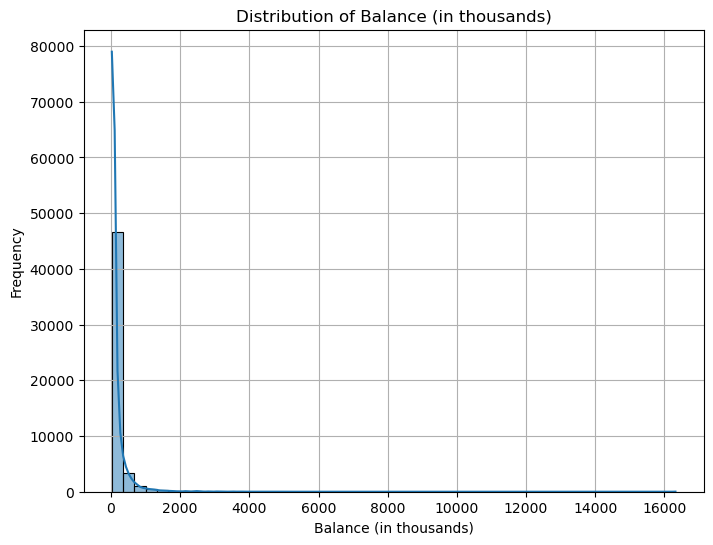

In [93]:
# Plot the distribution of balance using a histogram
plt.figure(figsize=(8,6))
sns.histplot(df_unique_visits['balance_thousands'], bins=50, kde=True)
plt.title('Distribution of Balance (in thousands)')
plt.xlabel('Balance (in thousands)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


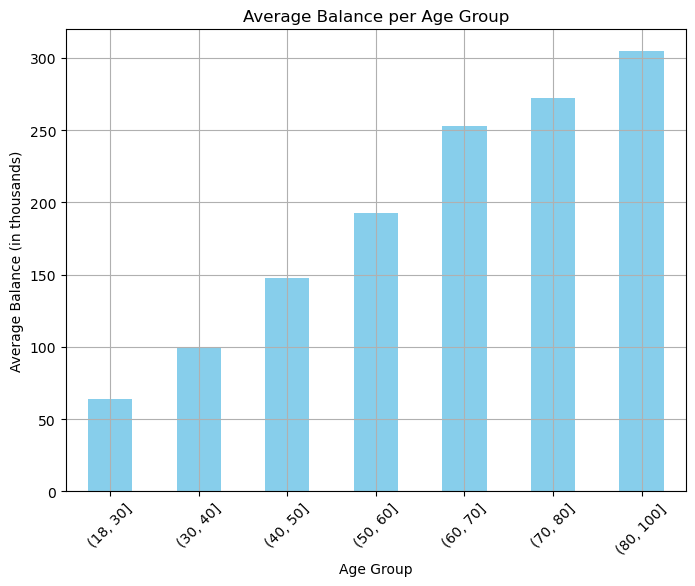

In [94]:
# Let's plot the average balance per age group for better visualization
plt.figure(figsize=(8,6))
average_balance_per_age_group.plot(kind='bar', color='skyblue')
plt.title('Average Balance per Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Balance (in thousands)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [97]:



# Re-create the age bins
bins = [18, 30, 40, 50, 60, 70, 80, 100]
df_unique_visits['age_bin'] = pd.cut(df_unique_visits['age'], bins)

# Calculate the completion rate for each age group using the 'funnel_success' column
completion_rate_per_age_group = df_unique_visits.groupby('age_bin')['funnel_success'].mean()

# Display the results


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2549851660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_visits['age_bin'] = pd.cut(df_unique_visits['age'], bins)
C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2549851660.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completion_rate_per_age_group = df_unique_visits.groupby('age_bin')['funnel_success'].mean()


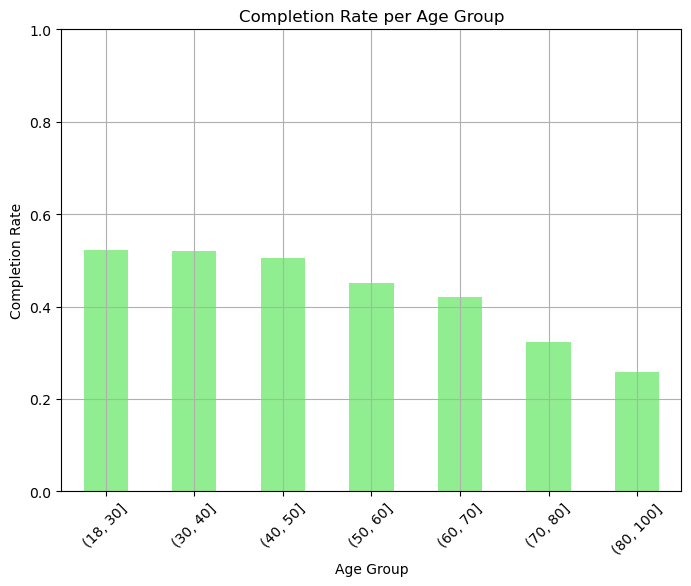

In [98]:
# It seems the necessary library is not loaded in this context, let's re-import the necessary libraries and plot again.

import matplotlib.pyplot as plt

# Visualize the completion rate per age group using a bar chart
plt.figure(figsize=(8,6))
completion_rate_per_age_group.plot(kind='bar', color='lightgreen')
plt.title('Completion Rate per Age Group')
plt.xlabel('Age Group')
plt.ylabel('Completion Rate')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 as completion rates are percentages
plt.grid(True)
plt.show()


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\4086750095.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completion_rate_test_control = df_unique_visits.groupby(['age_bin', 'variation'])['funnel_success'].mean().unstack()


<Figure size 1000x600 with 0 Axes>

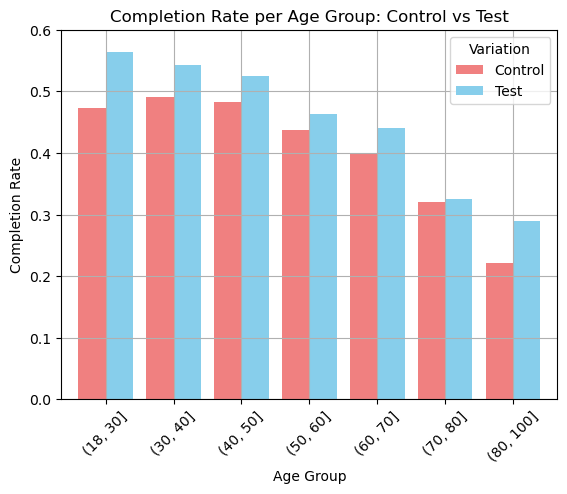

In [115]:
# Let's compare the completion rate for Control vs Test for each age group

# Group by both age_bin and variation to get the completion rates for each group
completion_rate_test_control = df_unique_visits.groupby(['age_bin', 'variation'])['funnel_success'].mean().unstack()

# Plot the comparison between Control and Test side by side
plt.figure(figsize=(10,6))
completion_rate_test_control.plot(kind='bar', color=['lightcoral', 'skyblue'], width=0.8)
plt.title('Completion Rate per Age Group: Control vs Test')
plt.xlabel('Age Group')
plt.ylabel('Completion Rate')
plt.xticks(rotation=45)
plt.ylim(0, 0.6)  # Completion rates are percentages
plt.legend(title='Variation')
plt.grid(True)
plt.show()


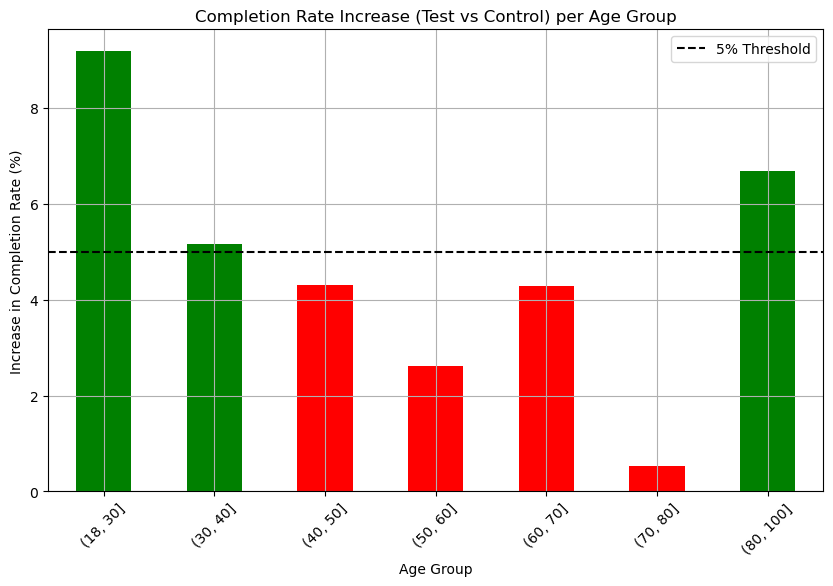

In [100]:
# Calculate the percentage difference between Test and Control for each age group
completion_rate_diff = (completion_rate_test_control['Test'] - completion_rate_test_control['Control']) * 100

# Define a threshold for cost-effectiveness (5% increase)
threshold = 5

# Plot the difference and highlight the age groups that meet or exceed the 5% increase
plt.figure(figsize=(10,6))
completion_rate_diff.plot(kind='bar', color=['red' if diff < threshold else 'green' for diff in completion_rate_diff])
plt.axhline(y=threshold, color='black', linestyle='--', label='5% Threshold')
plt.title('Completion Rate Increase (Test vs Control) per Age Group')
plt.xlabel('Age Group')
plt.ylabel('Increase in Completion Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2587417391.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y*100)}%' for y in ax.get_yticks()])


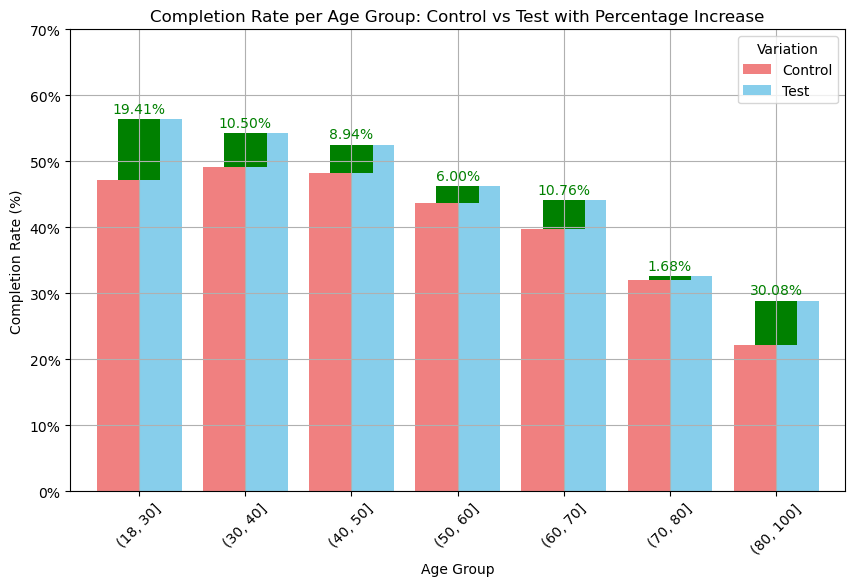

In [108]:
# Let's create a bar chart showing the portion of the Test bar that exceeds the Control bar
# and label the percentage increase for the Test group where applicable.

# Calculate the difference between Test and Control (for the labels)
completion_rate_diff_labels = ((completion_rate_test_control['Test']  - completion_rate_test_control['Control']) / completion_rate_test_control['Control']) * 100

# Let's update the plot with the y-axis in percentages and reduce the height of the bars to 80% max.
fig, ax = plt.subplots(figsize=(10,6))

# Plot Control and Test bars side by side
completion_rate_test_control.plot(kind='bar', ax=ax, color=['lightcoral', 'skyblue'], width=0.8)

# Overlay the portion of the Test bar that is above the Control
for idx in range(len(completion_rate_test_control)):
    control = completion_rate_test_control['Control'].iloc[idx]
    test = completion_rate_test_control['Test'].iloc[idx]
    if test > control:
        ax.bar(idx, test - control, bottom=control, width=0.4, color='green')
        # Label the percentage increase
        diff_percentage = completion_rate_diff_labels.iloc[idx]
        ax.text(idx, test + 0.005, f'{diff_percentage:.2f}%', ha='center', va='bottom', fontsize=10, color='green')

# Add labels and title
ax.set_title('Completion Rate per Age Group: Control vs Test with Percentage Increase')
ax.set_xlabel('Age Group')
ax.set_ylabel('Completion Rate (%)')

# Set y-axis to show percentages and limit the height to 80%
ax.set_ylim(0, 0.7)
ax.set_yticklabels([f'{int(y*100)}%' for y in ax.get_yticks()])

ax.legend(['Control', 'Test'], title='Variation')

plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [105]:
# Calculate the overall conversion rate for Control and Test
overall_conversion_control = df_unique_visits[df_unique_visits['variation'] == 'Control']['funnel_success'].mean()
overall_conversion_test = df_unique_visits[df_unique_visits['variation'] == 'Test']['funnel_success'].mean()

# Calculate the percentage increase
percentage_increase = ((overall_conversion_test - overall_conversion_control) / overall_conversion_control) * 100

overall_conversion_control, overall_conversion_test, percentage_increase


(0.44102608172560476, 0.4882441046361768, 10.70640147308791)

C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2803249842.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_visits['balance_bin'] = pd.cut(df_unique_visits['balance_thousands'] * 1000, bins=bins, labels=bin_labels)
C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\2803249842.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completion_rate_balance_bin = df_unique_visits.groupby(['balance_bin', 'variation'])['funnel_success'].mean().unstack()


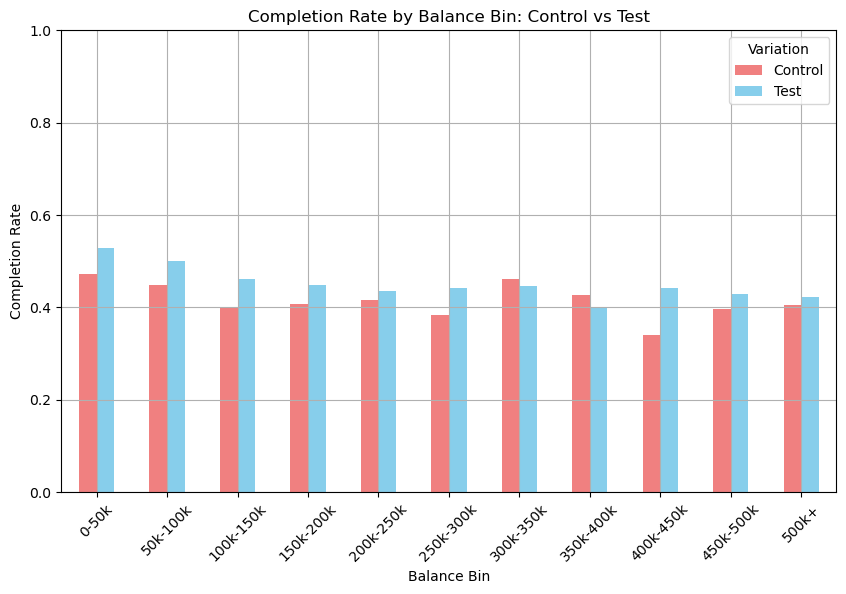

In [109]:
# First, we create the balance bins. We'll define the bin ranges and label them accordingly.
import numpy as np

# Define the balance bins: 0-50k, 50k-100k, ..., up to 500k, and 500k+
bins = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, np.inf]
bin_labels = ['0-50k', '50k-100k', '100k-150k', '150k-200k', '200k-250k', '250k-300k', '300k-350k', '350k-400k', 
              '400k-450k', '450k-500k', '500k+']

# Assign each balance value to a bin
df_unique_visits['balance_bin'] = pd.cut(df_unique_visits['balance_thousands'] * 1000, bins=bins, labels=bin_labels)

# Calculate completion rates for each balance bin in both the Control and Test groups
completion_rate_balance_bin = df_unique_visits.groupby(['balance_bin', 'variation'])['funnel_success'].mean().unstack()

# Plot the results
completion_rate_balance_bin.plot(kind='bar', figsize=(10, 6), color=['lightcoral', 'skyblue'])
plt.title('Completion Rate by Balance Bin: Control vs Test')
plt.xlabel('Balance Bin')
plt.ylabel('Completion Rate')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Variation')
plt.grid(True)
plt.show()


In [111]:
# Let's proceed with creating balance bins for analysis, as well as perform hypothesis testing

# Define the balance bins: 0-50k, 50k-100k, ..., up to 500k, and 500k+
bins = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, np.inf]
bin_labels = ['0-50k', '50k-100k', '100k-150k', '150k-200k', '200k-250k', '250k-300k', '300k-350k', '350k-400k', 
              '400k-450k', '450k-500k', '500k+']

# Assign each balance value to a bin
df_unique_visits['balance_bin'] = pd.cut(df_unique_visits['balance_thousands'] * 1000, bins=bins, labels=bin_labels)

# Calculate the completion rate for each balance bin in Control and Test groups
completion_rate_balance_bin = df_unique_visits.groupby(['balance_bin', 'variation'])['funnel_success'].mean().unstack()

# Perform hypothesis testing: 
# Let's test whether completion rates differ significantly between lower balance (0-50k) and higher balance (>500k)
from scipy import stats

# Filter for Control and Test group data for low and high balance accounts
low_balance_control = df_unique_visits[(df_unique_visits['balance_bin'] == '0-50k') & (df_unique_visits['variation'] == 'Control')]['funnel_success']
high_balance_control = df_unique_visits[(df_unique_visits['balance_bin'] == '500k+') & (df_unique_visits['variation'] == 'Control')]['funnel_success']

low_balance_test = df_unique_visits[(df_unique_visits['balance_bin'] == '0-50k') & (df_unique_visits['variation'] == 'Test')]['funnel_success']
high_balance_test = df_unique_visits[(df_unique_visits['balance_bin'] == '500k+') & (df_unique_visits['variation'] == 'Test')]['funnel_success']

# Perform independent t-tests for Control and Test groups
t_stat_control, p_value_control = stats.ttest_ind(low_balance_control, high_balance_control, equal_var=False)
t_stat_test, p_value_test = stats.ttest_ind(low_balance_test, high_balance_test, equal_var=False)

# Display results
completion_rate_balance_bin, (t_stat_control, p_value_control), (t_stat_test, p_value_test)


C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\3388344478.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_visits['balance_bin'] = pd.cut(df_unique_visits['balance_thousands'] * 1000, bins=bins, labels=bin_labels)
C:\Users\olivi\AppData\Local\Temp\ipykernel_36560\3388344478.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completion_rate_balance_bin = df_unique_visits.groupby(['balance_bin', 'variation'])['funnel_success'].mean().unstack()


(variation     Control      Test
 balance_bin                    
 0-50k        0.472458  0.527789
 50k-100k     0.449447  0.499685
 100k-150k    0.401815  0.462552
 150k-200k    0.407774  0.449195
 200k-250k    0.416210  0.435855
 250k-300k    0.384615  0.441388
 300k-350k    0.462151  0.446281
 350k-400k    0.427350  0.400000
 400k-450k    0.340176  0.442211
 450k-500k    0.396624  0.429022
 500k+        0.404570  0.421622,
 (4.8858401781639635, 1.107849294929207e-06),
 (8.476013668538968, 3.8460904670741825e-17))

In [112]:
# Perform hypothesis testing on all balance bins for both Control and Test groups.
# We'll conduct pairwise t-tests between balance bins for both groups.

# Create lists to store the results of t-tests for each comparison.
control_results = []
test_results = []

# Get the unique balance bins
balance_bins = df_unique_visits['balance_bin'].unique()

# Perform pairwise t-tests between each pair of balance bins for Control and Test groups
for i in range(len(balance_bins)):
    for j in range(i+1, len(balance_bins)):
        bin_i = balance_bins[i]
        bin_j = balance_bins[j]
        
        # Control group t-test between bin i and bin j
        control_bin_i = df_unique_visits[(df_unique_visits['balance_bin'] == bin_i) & (df_unique_visits['variation'] == 'Control')]['funnel_success']
        control_bin_j = df_unique_visits[(df_unique_visits['balance_bin'] == bin_j) & (df_unique_visits['variation'] == 'Control')]['funnel_success']
        t_stat_control, p_value_control = stats.ttest_ind(control_bin_i, control_bin_j, equal_var=False)
        control_results.append((bin_i, bin_j, t_stat_control, p_value_control))
        
        # Test group t-test between bin i and bin j
        test_bin_i = df_unique_visits[(df_unique_visits['balance_bin'] == bin_i) & (df_unique_visits['variation'] == 'Test')]['funnel_success']
        test_bin_j = df_unique_visits[(df_unique_visits['balance_bin'] == bin_j) & (df_unique_visits['variation'] == 'Test')]['funnel_success']
        t_stat_test, p_value_test = stats.ttest_ind(test_bin_i, test_bin_j, equal_var=False)
        test_results.append((bin_i, bin_j, t_stat_test, p_value_test))

# Convert the results into DataFrames for easy viewing
control_results_df = pd.DataFrame(control_results, columns=['Balance Bin 1', 'Balance Bin 2', 'T-statistic', 'P-value'])
test_results_df = pd.DataFrame(test_results, columns=['Balance Bin 1', 'Balance Bin 2', 'T-statistic', 'P-value'])